Paired TAM (transcient abnormal myleoproliferation) vs AML (acute myeloid leukemia) analysis of patients with the co-occuring condition of Down Syndrome using DESeq2 on IJC counts obtained from rMATS analysis.

Using a matrix constructed from Kids First Workflow V4 done on single runs, a series of scripts were created and are stored in this repository.  For each of the splicing types, all the runs considered for analysis are pooled and normalized to have a non-redundant set of splicing events.  A matrix is then constructed for each of the samples to be analyzed.  

Each splicing type has a bed file for visualizaiton in UCSC Genome browser of all the events, as well as created a matrix of the single runs normalized to the non-redundant union of files.  Both the source and the normalized bed file are available to ensure interprebility of results. 

Using associative arrays in an awk script, it was a rapid way to transform the individual counts from each of the individual runs into a matrix that facilitated analysis.

Using annotations obtained from the rMATS run that provided the coordinates of each of the splicing events as well as the gene that the junctions came from and the count of the reads that overlapped the junctions.   
 
Limma in this notebook is used to perform analysis of these junction counts provided by the rMATS routine.  Using these counts as junction expression.

Between the splicing event differences and the expression differences, between paired samples, biological functional differences may be obtained.

In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos = "https://cloud.r-project.org")

Bioconductor version '3.18' is out-of-date; the current release version '3.19'
  is available with R version '4.4'; see https://bioconductor.org/install



In [2]:
BiocManager::install("dplyr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'dplyr'”
Old packages: 'bbmle', 'BH', 'BiocManager', 'bitops', 'bslib', 'cachem',
  'caTools', 'cli', 'coda', 'codetools', 'colorspace', 'cpp11', 'crayon',
  'crosstalk', 'curl', 'data.table', 'DESeq2', 'digest', 'edgeR', 'evaluate',
  'farver', 'fastDummies', 'fastmap', 'fitdistrplus', 'future', 'GenomeInfoDb',
  'ggplot2', 'ggrepel', 'gtable', 'highr', 'htmlwidgets', 'kernlab',
  'KernSmooth', 'knitr', 'lifecycle', 'locfit', 'matrixStats', 'munsell',
  'mvtnorm', 'nlme', 'openssl', 'parallelly', 'pbdZMQ', 'plotly', 'polyclip',
  'RANN', 'Rcpp', 'RcppArmadillo', 'RcppEigen', 'RCurl', 'repr', 'retic

In [3]:
library(Glimma)
library(dplyr)
library(edgeR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma



In [4]:
setwd("/Users/annedeslattesmays/Scitechcon\ Dropbox/Anne\ DeslattesMays/projects/post-rmats-single-run/TAM.AML.all/A3SS_calculate")

In [5]:
getwd()

[1] "/Users/annedeslattesmays/Scitechcon Dropbox/Anne DeslattesMays/projects/post-rmats-single-run/TAM.AML.all/A3SS_calculate"

In [6]:
cts <- as.matrix(read.csv("A3SS.IJC.w.coordinates.matrix.csv",sep=",",row.names="ID"))

In [7]:
dim(cts)

[1] 14527   126

In [8]:
cts[1:3,11:dim(cts)[2]]

,PASNSP.03A,PASWXF.03A,PASXCL.03A,PASXFP.03A,PASZBH.03A,PATBFK.03A,PATDXB.03A,PATHYW.03A,PATJSM.03A,PATJTW.03A,⋯,PAYEGL.03A,PAYFEJ.03A,PAYFLR.03A,PAYJHN.03A,PAYJHS.03A,PAYLHE.03A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,19,0,0,0,0,0,0,0,0,0,⋯,0,0,0,9,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [9]:
featureData <- data.frame(cts[,1:10])
featureData[1:3,]

,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSG00000283761.1,ENSG00000283761,chr1,+,100078450,100080659,100080495,100080659,100067976,100068195
2,ENSG00000283761.1,ENSG00000283761,chr1,+,100078450,100080659,100080495,100080659,100077164,100077277
3,ENSG00000122435.11,TRMT13,chr1,+,100140407,100141019,100140851,100141019,100140181,100140251


In [10]:
featureData <- featureData[,c(1,2)]

In [11]:
head(featureData,2)

,GeneID,geneSymbol
,<chr>,<chr>
1,ENSG00000283761.1,ENSG00000283761
2,ENSG00000283761.1,ENSG00000283761


In [12]:
cts <- data.matrix(cts[,11:dim(cts)[2]])
mode(cts) <- "integer"
is.integer(cts)

[1] TRUE

In [13]:
dim(cts)
head(cts,2)

[1] 14527   116

,PASNSP.03A,PASWXF.03A,PASXCL.03A,PASXFP.03A,PASZBH.03A,PATBFK.03A,PATDXB.03A,PATHYW.03A,PATJSM.03A,PATJTW.03A,⋯,PAYEGL.03A,PAYFEJ.03A,PAYFLR.03A,PAYJHN.03A,PAYJHS.03A,PAYLHE.03A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,19,0,0,0,0,0,0,0,0,0,⋯,0,0,0,9,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [14]:
colnames(cts)

[1] "PASNSP.03A"     "PASWXF.03A"     "PASXCL.03A"     "PASXFP.03A"    
  [5] "PASZBH.03A"     "PATBFK.03A"     "PATDXB.03A"     "PATHYW.03A"    
  [9] "PATJSM.03A"     "PATJTW.03A"     "PATMYU.03A"     "PATSAA.03A"    
 [13] "PATSBU.03A"     "PATUHH.03A"     "PATYHN.03A"     "PAUCCI.03A"    
 [17] "PAUCWF.03A"     "PAUFEM.03A"     "PAUGFW.03A"     "PAUGSR.03A"    
 [21] "PAUIRS.03A"     "PAUJSX.03A"     "PAUJUA.03A"     "PAUKTL.03A"    
 [25] "PAUMEU.03A"     "PAURGT.03A"     "PAURGZ.03A"     "PAUUSG.03A"    
 [29] "PAUVKB.03A"     "PAUVKY.03A"     "PAUVKY.40A"     "PAUWDM.03A"    
 [33] "PAUWDN.03A"     "PAUWWN.03A"     "PAUXAT.03A"     "PAUXEH.03A"    
 [37] "PAUYAY.03A"     "PAVCVG.03A"     "PAVDZT.03A"     "PAVECW.03A"    
 [41] "PAVESU.03A"     "PAVIIZ.03A"     "PAVKZU.03A"     "PAVLZB.03A"    
 [45] "PAVMSZ.03A"     "PAVNSJ.03A"     "PAVNXY.03A"     "PAVPJC.03A"    
 [49] "PAVRGG.03A"     "PAVVPL.03A"     "PAVWDK.03A"     "PAVWVF.03A"    
 [53] "PAVXBW.03A"     "PAWBDC.03A"     "PAWCAY.03A"     "PAWCPC.03A"    
 [57] "PAWDIN.03A"     "PAWEUI.03A"     "PAWFKB.03A"     "PAWGFN.03A"    
 [61] "PAWGHI.03A"     "PAWGIG.03A"     "PAWHHS.03A"     "PAWHSD.03A"    
 [65] "PAWHSD.40A"     "PAWIAD.03A"     "PAWJDZ.03A"     "PAWKFB.03A"    
 [69] "PAWRJN.03A"     "PAWSIP.03A"     "PAWSNZ.03A"     "PAWSNZ.40A"    
 [73] "PAWSUI.03A"     "PAWVNF.03A"     "PAWVRU.03A"     "PAWWPI.03A"    
 [77] "PAWXEX.03A"     "PAWXPM.03A"     "PAWYII.03A"     "PAWYKF.03A"    
 [81] "PAXAWN.03A"     "PAXBAL.03A"     "PAXBFM.03A"     "PAXCUK.03A"    
 [85] "PAXDHB.03A"     "PAXDWD.03A"     "PAXGLA.03A"     "PAXHDZ.03A"    
 [89] "PAXHVP.03A"     "PAXHYL.03A"     "PAXJYG.03A"     "PAXKRG.03A"    
 [93] "PAXNFN.03A"     "PAXNKT.03A"     "PAXPLA.03A"     "PAXSBH.03A"    
 [97] "PAXSSI.03A"     "PAXWGW.03A"     "PAXWZW.03A"     "PAXXCC.03A"    
[101] "PAXZJT.03A"     "PAXZLD.03A"     "PAYAXU.03A"     "PAYDIX.03A"    
[105] "PAYDXU.03A"     "PAYDYT.03A"     "PAYEGL.03A"     "PAYFEJ.03A"    
[109] "PAYFLR.03A"     "PAYJHN.03A"     "PAYJHS.03A"     "PAYLHE.03A"    
[113] "X_1_PAUTLA.03A" "X_1_PAUTLA.40A" "X_1_PAVUDU.03A" "X_1_PAVUDU.40A"

In [15]:
colnames(cts[,c(113:116)])

[1] "X_1_PAUTLA.03A" "X_1_PAUTLA.40A" "X_1_PAVUDU.03A" "X_1_PAVUDU.40A"

I tried to rename colnames but it did not rename the existing object, rather it created a new object.

From code co-pilot: The issue with your code arises from the fact that when you use subsetting in R with cts[, c(113:116)], it returns a new object, and changing the column names of this new object does not affect the original data frame. To reassign the column names in the original data frame, you need to directly access and modify the colnames attribute of the cts data frame.


In [16]:
# Assign new column names directly to the specified columns
colnames(cts)[c(113:116)] <- c("PAUTLA.03A", "PAUTLA.40A", "PAVUDU.03A", "PAVUDU.40A")

# Verify the column names
colnames(cts)[c(113:116)]

[1] "PAUTLA.03A" "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

The PAWHSD samples are not TAM and AML but in fact TAM and TAM - the resulting heatmap when included showed they clustered together.  We will eliminate them from subsequent analyses.   To find and replace we need to work on the existing object. Get the mask object (which columns equal PAWHSD).

In [17]:
dim (cts)
# Find column numbers for column names that contain "PAWHSD"
column_numbers <- grep("PAWHSD", colnames(cts))

# Remove these columns from the cts data frame
cts <- cts[, -column_numbers]
dim(cts)

[1] 14527   116

[1] 14527   114

In [18]:
coldata <- read.csv("/Users/annedeslattesmays/Scitechcon\ Dropbox/Anne\ DeslattesMays/projects/post-rmats-single-run/design/design_all_matrix.csv", row.names=1)

In [19]:
head(coldata)

,patient,condition,paired
,<chr>,<chr>,<chr>
PAUVKY.03A,PAUVKY,preAML,yes
PAUVKY.40A,PAUVKY,AML,yes
PAUTLA.03A,PAUTLA,preAML,yes
PAUTLA.40A,PAUTLA,AML,yes
PAVUDU.03A,PAVUDU,preAML,yes
PAVUDU.40A,PAVUDU,AML,yes


In [20]:
# Create a new column 'name' with rownames
coldata$name <- rownames(coldata)
head(coldata)

,patient,condition,paired,name
,<chr>,<chr>,<chr>,<chr>
PAUVKY.03A,PAUVKY,preAML,yes,PAUVKY.03A
PAUVKY.40A,PAUVKY,AML,yes,PAUVKY.40A
PAUTLA.03A,PAUTLA,preAML,yes,PAUTLA.03A
PAUTLA.40A,PAUTLA,AML,yes,PAUTLA.40A
PAVUDU.03A,PAVUDU,preAML,yes,PAVUDU.03A
PAVUDU.40A,PAVUDU,AML,yes,PAVUDU.40A


In [21]:
# Filter for preAML paired samples
preAML_paired_samples <- coldata %>%
  filter(condition == "preAML" & paired == "yes") %>%
  pull(name)

# Filter for AML paired samples
AML_paired_samples <- coldata %>%
  filter(condition == "AML" & paired == "yes") %>%
  pull(name)

# Filter the unpaired samples
noAML_unpaired_samples <- coldata %>% 
   filter(condition == "noAML" & paired == "no") %>%
   pull (name)

preAML_unpaired_samples <- coldata %>%
   filter (condition == "preAML" & paired == "no") %>%
   pull (name)
length(preAML_paired_samples)
length(AML_paired_samples)
length(preAML_unpaired_samples)
length(noAML_unpaired_samples)

[1] 4

[1] 4

[1] 7

[1] 99

In [22]:
# Select columns corresponding to preAML paired samples
cts_preAML_paired <- cts[, colnames(cts) %in% preAML_paired_samples]

# Select columns corresponding to AML paired samples
cts_AML_paired <- cts[, colnames(cts) %in% AML_paired_samples]

# Select columns corresponding to TAM (no progress to AML) unpaired samples
cts_noAML_unpaired <- cts[, colnames(cts) %in% noAML_unpaired_samples]

# Select columns corresponding to TAM (no progress to AML) unpaired samples
cts_preAML_unpaired <- cts[, colnames(cts) %in% preAML_unpaired_samples]

# Display the first few rows of the filtered dataframes
head(cts_preAML_paired)
head(cts_AML_paired)
head(cts_noAML_unpaired)
head(cts_preAML_unpaired)

,PAUVKY.03A,PAWSNZ.03A,PAUTLA.03A,PAVUDU.03A
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,36,83,50,41
5,0,0,50,0
6,0,82,0,40


,PAUVKY.40A,PAWSNZ.40A,PAUTLA.40A,PAVUDU.40A
1,0,0,0,0
2,151,0,0,0
3,0,0,0,0
4,46,45,52,69
5,0,0,0,0
6,48,0,0,66


,PASNSP.03A,PASWXF.03A,PASXCL.03A,PASXFP.03A,PASZBH.03A,PATBFK.03A,PATDXB.03A,PATHYW.03A,PATJSM.03A,PATJTW.03A,⋯,PAYAXU.03A,PAYDIX.03A,PAYDXU.03A,PAYDYT.03A,PAYEGL.03A,PAYFEJ.03A,PAYFLR.03A,PAYJHN.03A,PAYJHS.03A,PAYLHE.03A
1,19,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,9,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,51,51,40,36,59,23,44,51,36,75,⋯,35,26,45,67,34,32,62,41,0,37
5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,51,54,41,0,0,22,0,0,0,0,⋯,0,0,46,0,33,0,0,0,0,0


,PAUWWN.03A,PAVLZB.03A,PAVWDK.03A,PAVXBW.03A,PAXDWD.03A,PAXKRG.03A,PAXZJT.03A
1,0,0,0,0,0,0,0
2,143,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,52,25,51,32,26,61,42
5,0,26,0,0,0,0,0
6,0,26,0,32,25,61,0


In [23]:

# Ensure colnames of cts match the 'name' column in design_all_matrix
# Assuming 'cts' is already loaded in the R environment
#matching_cols <- colnames(cts) %in% 

all(coldata$name %in% colnames(cts))

[1] TRUE

In [24]:
missing_names <- coldata$name[!coldata$name %in% colnames(cts)]

# Print the missing names
cat("The following names are missing from cts:\n")
print(missing_names)


The following names are missing from cts:
character(0)


This is an interesting catch - this was an inadvertant add -- I had removed it from all the references so I don't include it going forward.  But did not remove it from the design matrix.

**Key Points:**

1. **Threshold Definition:** Define a count threshold (e.g., 1000).
2. **Criteria for Selection:** Define a function to select rows that have counts above the threshold in at least half of the samples in each condition.
3. **Row Selection:** Apply this criteria to each condition's sub-matrix.
4. **Combine Rows:** Combine the selected rows from all conditions to form the final matrix.
5. **MDS Plot:** Proceed with the MDS plot using the final matrix.
This approach ensures that the rows included in the final matrix have significant counts in most of the samples for each condition, which should help to maximize the differences in the signals.

In [25]:
# Select columns corresponding to preAML paired samples
cts_paired <- cts[, c(colnames(cts) %in% preAML_paired_samples | colnames(cts) %in% AML_paired_samples)]
dim(cts_paired)

[1] 14527     8

In [26]:
cts_unpaired <- cts[, c(colnames(cts) %in% preAML_unpaired_samples | colnames(cts) %in% noAML_unpaired_samples)]
dim(cts_unpaired)

[1] 14527   106

In [27]:
colnames(cts_paired)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [36]:
coldata_paired <- read.csv("/Users/annedeslattesmays/Scitechcon\ Dropbox/Anne\ DeslattesMays/projects/post-rmats-single-run/design/design_paired_matrix.csv", row.names=1)
coldata_unpaired_noAML_paired_AML      <- read.csv("/Users/annedeslattesmays/Scitechcon\ Dropbox/Anne\ DeslattesMays/projects/post-rmats-single-run/design/design_unpaired_noAML_paired_AML.csv", row.names=1)
coldata_unpaired_preAML_paired_AML     <- read.csv("/Users/annedeslattesmays/Scitechcon\ Dropbox/Anne\ DeslattesMays/projects/post-rmats-single-run/design/design_unpaired_preAML_paired_AML.csv", row.names=1)
coldata_unpaired_noAML_unpaired_preAML <- read.csv("/Users/annedeslattesmays/Scitechcon\ Dropbox/Anne\ DeslattesMays/projects/post-rmats-single-run/design/design_unpaired_noAML_unpaired_preAML.csv", row.names=1)

In [38]:
head(coldata_paired,2)
head(coldata_unpaired_noAML_paired_AML,2)
head(coldata_unpaired_preAML_paired_AML,2)
head(coldata_unpaired_noAML_unpaired_preAML,2)

,patient,condition
,<chr>,<chr>
PAUVKY-03A,PAUVKY,preAML
PAUVKY-40A,PAUVKY,AML


,patient,condition,paired
,<chr>,<chr>,<chr>
PAUVKY.40A,PAUVKY,AML,yes
PAUTLA.40A,PAUTLA,AML,yes


,patient,condition,paired
,<chr>,<chr>,<chr>
PAUVKY.40A,PAUVKY,AML,yes
PAUTLA.40A,PAUTLA,AML,yes


,patient,condition,paired
,<chr>,<chr>,<chr>
PAUWWN.03A,PAUWWN,preAML,no
PAVLZB.03A,PAVLZB,preAML,no


In [39]:
coldata_paired
dim(coldata_paired)

,patient,condition
,<chr>,<chr>
PAUVKY-03A,PAUVKY,preAML
PAUVKY-40A,PAUVKY,AML
PAWSNZ-03A,PAWSNZ,preAML
dPAWSNZ-40A,PAWSNZ,AML
PAUTLA-03A,PAUTLA,preAML
PAUTLA-40A,PAUTLA,AML
PAVUDU-03A,PAVUDU,preAML
PAVUDU-40A,PAVUDU,AML


[1] 8 2

In [40]:
# Load necessary libraries
library(dplyr)

# Assuming coldata is already defined and has row.names
# Assuming cts_paired is already defined

# Identify the columns for preAML and paired == "yes"
paired_preAML_cols <- rownames(coldata)[coldata$condition == "preAML" & coldata$paired == "yes"]

# Identify the columns for AML and paired == "yes"
paired_AML_cols <- rownames(coldata)[coldata$condition == "AML" & coldata$paired == "yes"]

# Convert column names to indices
paired_preAML_indices <- which(colnames(cts_paired) %in% paired_preAML_cols)
paired_AML_indices <- which(colnames(cts_paired) %in% paired_AML_cols)

# Define the threshold
threshold <- 10  # You can change this to 10, 100, etc.

# Condition 1: Rows with count > threshold in all paired preAML columns
paired_preAML_rows_condition <- apply(cts_paired[, paired_preAML_indices], 1, function(row) all(row > threshold))
paired_preAML_matrix <- cts_paired[paired_preAML_rows_condition, paired_preAML_indices]
dim(paired_preAML_matrix)

# Condition 2: Rows with count > threshold in all paired AML columns
paired_AML_rows_condition <- apply(cts_paired[, paired_AML_indices], 1, function(row) all(row > threshold))
paired_AML_matrix <- cts_paired[paired_AML_rows_condition, paired_AML_indices]
dim(paired_AML_matrix)

[1] 4691    4

[1] 4319    4

In [41]:

# Identify the columns for preAML and paired == "no"
unpaired_preAML_cols <- rownames(coldata)[coldata$condition == "preAML" & coldata$paired == "no"]

# Identify the columns for noAML and paired == "no"
unpaired_noAML_cols <- rownames(coldata)[coldata$condition == "noAML" & coldata$paired == "no"]

# Convert column names to indices
unpaired_preAML_indices <- which(colnames(cts_unpaired) %in% unpaired_preAML_cols)
unpaired_noAML_indices  <- which(colnames(cts_unpaired) %in% unpaired_noAML_cols)

# Condition 1: Rows with count > threshold in all unpaired preAML columns
unpaired_preAML_rows_condition <- apply(cts_unpaired[, unpaired_preAML_indices], 1, function(row) all(row > threshold))
unpaired_preAML_matrix <- cts_unpaired[unpaired_preAML_rows_condition, unpaired_preAML_indices]
dim(unpaired_preAML_matrix)

# Condition 2: Rows with count > threshold in all unpaired noAML columns
unpaired_noAML_rows_condition <- apply(cts_unpaired[, unpaired_noAML_indices], 1, function(row) all(row > threshold))
unpaired_noAML_matrix <- cts_unpaired[unpaired_noAML_rows_condition, unpaired_noAML_indices]
dim(unpaired_noAML_matrix)

[1] 3358    7

[1] 1611   99

In [42]:
# Extract sample names for different conditions
paired_preAML_samples <- coldata$name[coldata$condition == "preAML" & coldata$paired == "yes"]
paired_AML_samples    <- coldata$name[coldata$condition == "AML"    & coldata$paired == "yes"]

print(paired_preAML_samples)
print(paired_AML_samples)

# Filter paired data based on the threshold
paired_preAML_columns <- colnames(cts) %in% paired_preAML_samples
paired_AML_columns    <- colnames(cts) %in% paired_AML_samples

# Select columns for paired and unpaired samples
paired_data <- cts[, colnames(cts) %in% c(paired_preAML_samples, paired_AML_samples)]
dim(paired_data)
colnames(paired_data)
#
# make the final paired_matrix
#
# Combine the sub-matrices by keeping rows that satisfy either condition 1 or condition 2
#
paired_final_matrix <- cts_paired[paired_AML_rows_condition | paired_preAML_rows_condition, ]
dim(paired_final_matrix)
head(paired_final_matrix)


[1] "PAUVKY.03A" "PAUTLA.03A" "PAVUDU.03A" "PAWSNZ.03A"
[1] "PAUVKY.40A" "PAUTLA.40A" "PAVUDU.40A" "PAWSNZ.40A"


[1] 14527     8

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

[1] 5078    8

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
4,36,46,83,45,50,52,41,69
16,55,75,121,48,51,67,38,61
17,82,97,122,85,60,98,48,134
18,36,50,65,32,25,0,19,48
19,28,22,21,1,50,13,37,11
26,50,34,58,39,44,43,28,57



now make one of three unpaired preAML matrices

1. unpaired_preAML and paired AML
2. unpaired_noAML and paired AML
3. unpaired_noAML and unpaired preAML


In [43]:
unpaired_preAML_samples <- coldata$name[coldata$condition == "preAML" & coldata$paired == "no"]
unpaired_noAML_samples  <- coldata$name[coldata$condition == "noAML" & coldata$paired == "no"]
unpaired_final_matrix   <- cts_unpaired[unpaired_noAML_rows_condition | unpaired_preAML_rows_condition, ]
dim(unpaired_final_matrix)

[1] 3386  106

In [44]:
# can we make three matrices 
# 1. combining unpaired preAML with paired AML
# and a matrix
# 2. combining unpaired noAML with paired AML - we would expect the opposite behavior of a candidate as these samples
# do not progress to AML and we are comparing them with the small AML set we have.
# and a matrix
# 3. combining unpaired noAML with unpaired preAML
combined_unpaired_preAML_paired_AML_data      <- cts[, colnames(cts) %in% c(unpaired_preAML_samples, paired_AML_samples)]
combined_unpaired_noAML_paired_AML_data       <- cts[, colnames(cts) %in% c(unpaired_noAML_samples,  paired_AML_samples)]
combined_unpaired_noAML_unpaired_preAML_data  <- cts[, colnames(cts) %in% c(unpaired_noAML_samples,  unpaired_preAML_samples)]

combined_final_unpaired_preAML_paired_AML_matrix <- combined_unpaired_preAML_paired_AML_data[unpaired_preAML_rows_condition | 
                                                                                             paired_AML_rows_condition,]
combined_final_unpaired_noAML_paired_AML_matrix  <- combined_unpaired_noAML_paired_AML_data [unpaired_noAML_rows_condition | 
                                                                                             paired_AML_rows_condition,]

combined_final_unpaired_noAML_unpaired_preAML_matrix  <- combined_unpaired_noAML_unpaired_preAML_data [unpaired_noAML_rows_condition |                                                                                              
                                                                                                       unpaired_preAML_rows_condition,]

dim(combined_final_unpaired_preAML_paired_AML_matrix)
dim(combined_final_unpaired_noAML_paired_AML_matrix)
dim(combined_final_unpaired_noAML_unpaired_preAML_matrix)


coldata_unpaired_preAML_paired_AML$condition     <- factor (coldata_unpaired_preAML_paired_AML$condition)
coldata_unpaired_noAML_paired_AML$condition      <- factor (coldata_unpaired_noAML_paired_AML$condition)
coldata_unpaired_noAML_unpaired_preAML$condition <- factor (coldata_unpaired_noAML_unpaired_preAML$condition)

levels(coldata_unpaired_noAML_paired_AML$condition)
levels(coldata_unpaired_preAML_paired_AML$condition)
levels(coldata_unpaired_noAML_unpaired_preAML$condition)

[1] 4514   11

[1] 4324  103

[1] 3386  106

[1] "AML"   "noAML"

[1] "AML"    "preAML"

[1] "noAML"  "preAML"

[1] 5078    8
[1] 8 2
[1] 5078    8
[1] 8


[1] 5078

[1] "PABPC1" "RPS3A"  "ACTB"   "PABPC1" "EEF1A1" "RPL18"

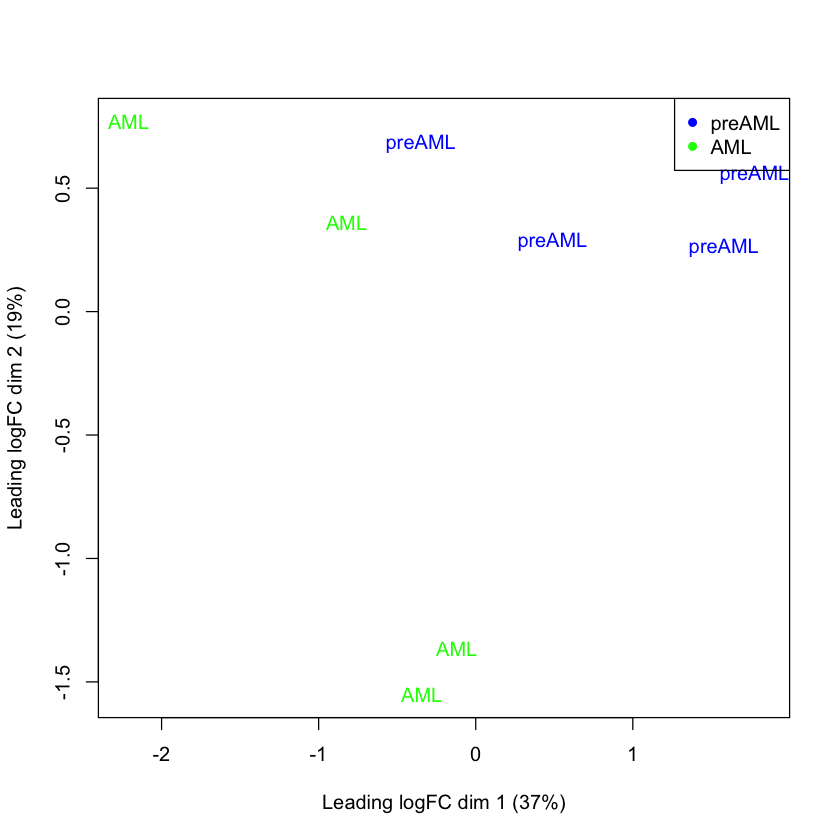

In [45]:
# Load necessary libraries
library(edgeR)
library(limma)


#
# Three limma/voom analyses to run:
# 1. paired analyses preAML to AML
# 2. unpaired analyses unpaired preAML to paired AML
# 3. unpaired analyses unpaired noAML to paired preAML
#

# 1. Paired analyses
#    key input matrices are:
#    a. coldata_paired
#    b. paired_final_matrix
#
# Assuming paired_final_matrix and coldata_paired are already defined
date<-"2024Aug22_A3SS_paired_preAML_paired_AML_"

paired_cts <- paired_final_matrix

# Check dimensions
print(dim(paired_cts))
print(dim(coldata_paired))

# Ensure coldata_paired has the same number of rows as paired_cts has columns
if (nrow(coldata_paired) != ncol(paired_cts)) {
  stop("The number of samples in coldata_paired and paired_cts do not match.")
}

#
# Begin Differential count analyses
# 
# Convert the count data to a DGEList object
#
dge <- DGEList(counts = paired_cts)

# Normalize the data using the TMM method
dge <- calcNormFactors(dge)

# Compute the log-transformed counts per million (CPM)
logCPM <- cpm(dge, log = TRUE, prior.count = 3)

# Ensure coldata_paired$condition is a factor and create a color palette
coldata_paired$condition <- factor(coldata_paired$condition, levels = c("preAML", "AML"))
color_palette <- c("blue", "green")

# Map the conditions to their respective colors
condition_colors <- color_palette[as.numeric(coldata_paired$condition)]

# Check lengths of logCPM and condition_colors
print(dim(logCPM))
print(length(condition_colors))

# Ensure the lengths match
if (ncol(logCPM) != length(condition_colors)) {
  stop("The number of col in logCPM and the length of condition_colors do not match.")
}

# Create MDS plot with colors for each condition
plotMDS(logCPM, col = condition_colors, labels = coldata_paired$condition)
legend("topright", legend = levels(coldata_paired$condition), col = color_palette, pch = 16)

group <- factor(coldata_paired$condition)

# Create the design matrix
design <- model.matrix(~0 + group)
colnames(design) <- levels(group)

fit <- lmFit(logCPM, design)
fit <- eBayes(fit, trend=TRUE)

de_results <- topTable(fit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(lookup)
head(featureData[lookup,2])

In [46]:
# There are too many values - lets reduce the size a bit more
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 236   6

In [47]:
lookup <- rownames(significant_genes)
df <- as.data.frame(coldata[,c("condition","patient")])

significant_expression <- dge[lookup,]
dim(significant_expression)
length(lookup)

[1] 236   8

[1] 236

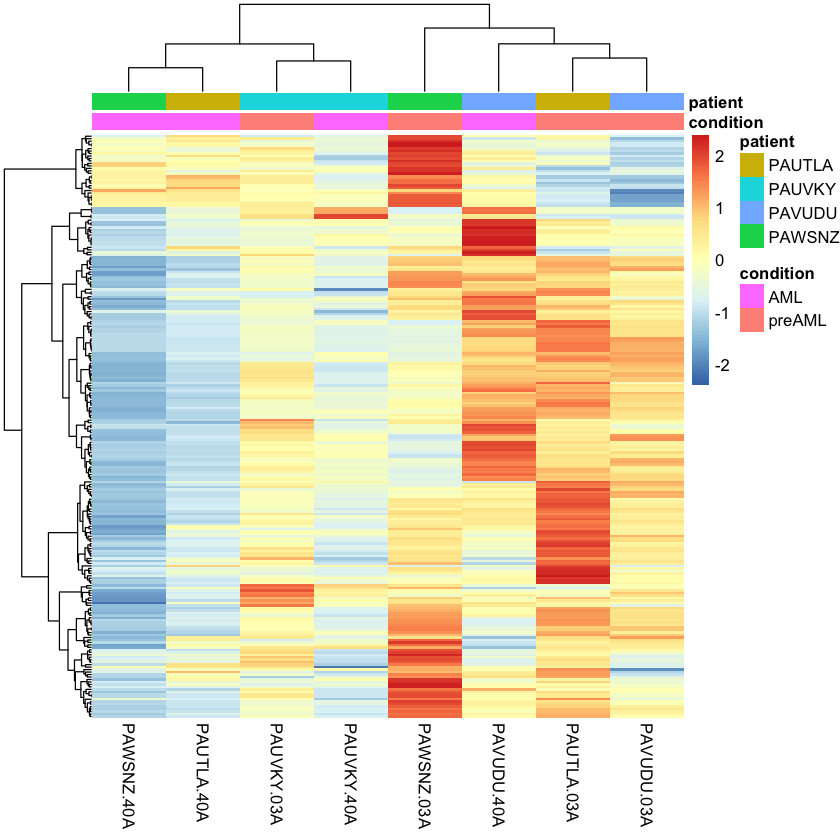

In [48]:
library("pheatmap")

significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

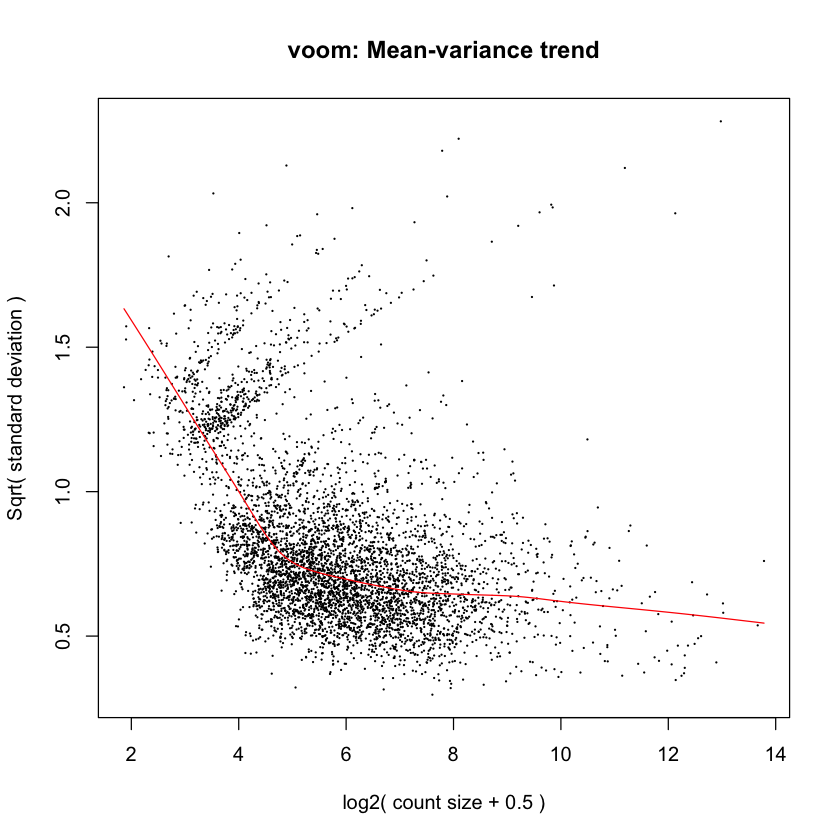

In [49]:
# voom 
v <- voom(dge, plot=TRUE, normalize="quantile")

In [50]:
vfit <- lmFit(v, design)
vfit <- eBayes(vfit, trend=TRUE)
de_results <- topTable(vfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 5078

[1] "RACK1"  "RPL13A" "PABPC1" "PABPC1" "RPS7"   "PTMA"

In [51]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 254   6

In [52]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

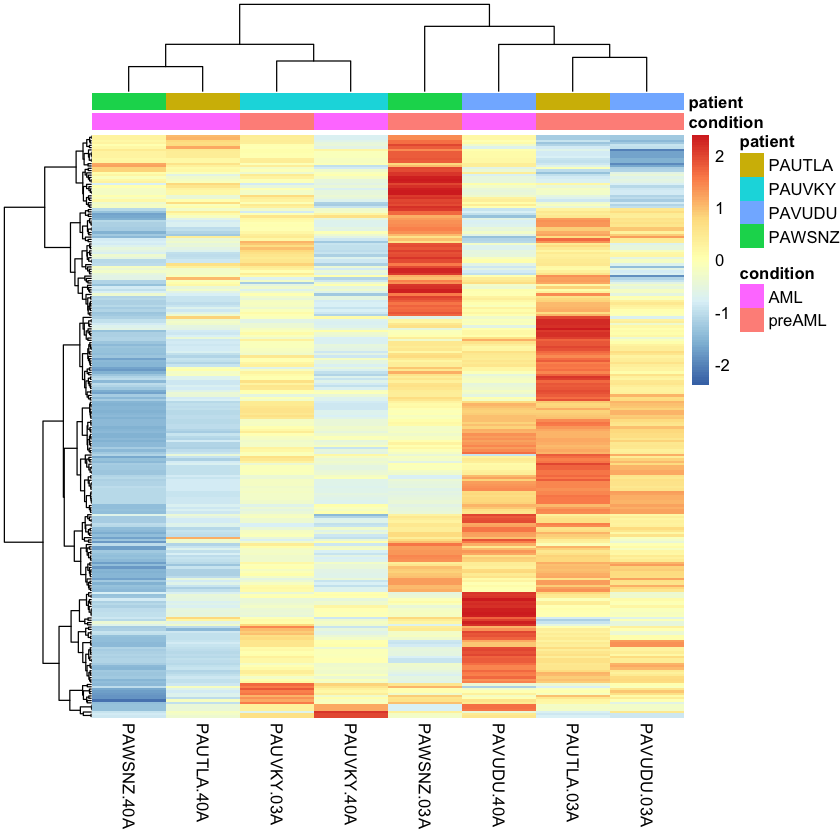

In [53]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [54]:
featureData[head(rownames(significant_expression),5),2]

[1] "RACK1"  "RPL13A" "PABPC1" "PABPC1" "RPS7"

In [55]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

[1] 254

In [56]:
top_significant_genes <- dge[rownames(significant_genes),]

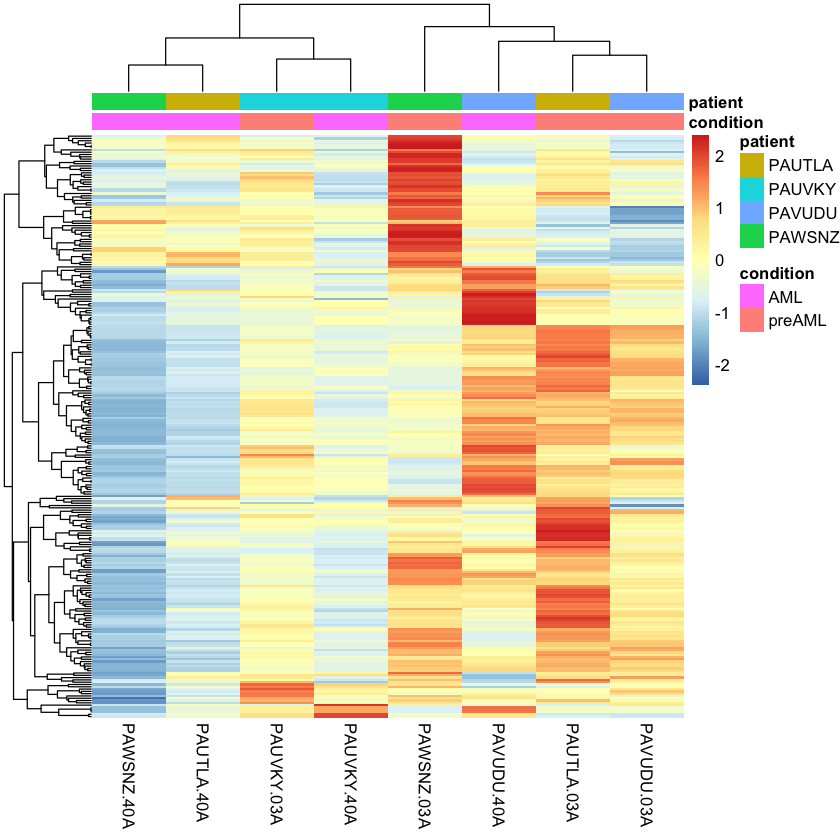

In [57]:
start=1
stop=length(top_gene_list)
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, 
                   cluster_rows5=TRUE, 
                   show_rownames=FALSE,
                   cluster_cols=TRUE, 
                   annotation_col=df, 
                   scale="row",
                   clustering_distance_cols = "minkowski", 
                   clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"voom_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

In [58]:
colnames(piece)
dim(piece)

# Convert column names to indices
paired_preAML_indices <- which(colnames(piece) %in% paired_preAML_cols)
paired_AML_indices  <- which(colnames(piece) %in% paired_AML_cols)
paired_preAML_indices
paired_AML_indices
# Order by preAML elements, followed by AML elements
piece_exp <- piece[,c(paired_preAML_indices,paired_AML_indices)]
colnames(piece_exp)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

[1] 254   8

[1] 1 3 5 7

[1] 2 4 6 8

[1] "PAUVKY.03A" "PAWSNZ.03A" "PAUTLA.03A" "PAVUDU.03A" "PAUVKY.40A"
[6] "PAWSNZ.40A" "PAUTLA.40A" "PAVUDU.40A"

In [59]:
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"voom_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"voom_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

In [60]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 4 major groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=4)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]

cluster_1_filename <- paste(paste(date, "voom_cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "voom_cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "voom_cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "voom_cluster_4", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)


[1] 254   2

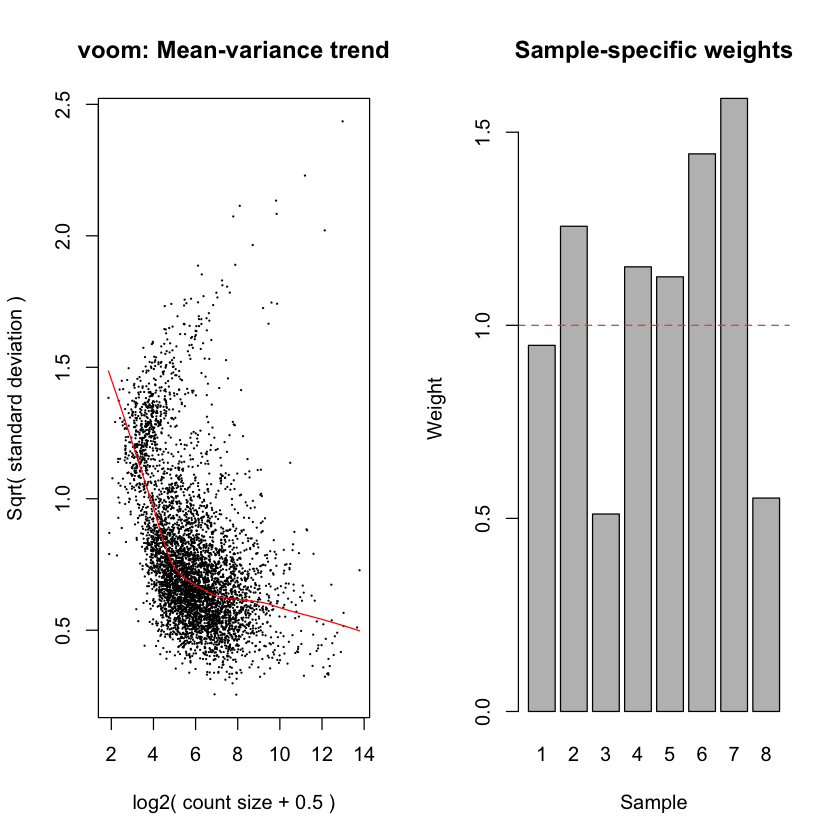

In [61]:
vwts <- voomWithQualityWeights(dge, design=design, normalize.method="quantile", plot=TRUE)

In [62]:
vwtsfit <- lmFit(vwts, design, weights = vwts$weights )
# no other weighting at this time.
 #* c(1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0))

In [63]:
vwtsfit <- eBayes(vwtsfit, trend=TRUE)
de_results <- topTable(vwtsfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 5078

[1] "PABPC1" "PABPC1" "RPL13A" "PTMA"   "ACTB"   "RPS7"

In [64]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 258   6

In [65]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]
head(significant_genes)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13253,12.83265,12.64620,130.6094,1.575364e-17,2.026575e-14,27.41518
13254,12.67129,12.57339,131.7206,1.447179e-17,2.026575e-14,27.36640
7567,13.10304,13.17478,123.6221,2.732617e-17,2.200918e-14,27.32136
8496,12.59132,12.52609,130.0922,1.639244e-17,2.026575e-14,27.27567
12929,13.93516,13.94486,112.5292,7.007486e-17,2.871819e-14,27.26266
8589,12.43594,12.41787,128.7211,1.822810e-17,2.026575e-14,27.15356


In [66]:
head(featureData[lookup,2])

[1] "PABPC1" "PABPC1" "RPL13A" "PTMA"   "ACTB"   "RPS7"

In [67]:
head(significant_expression)

An object of class "DGEList"
$counts
      PAUVKY.03A PAUVKY.40A PAWSNZ.03A PAWSNZ.40A PAUTLA.03A PAUTLA.40A
13253       5166       5193       7453       2793       6775       4424
13254       5365       4781       7191       2637       6890       3888
7567        7128       5698      12228       3973      10361       5197
8496        5067       4761       5836       2325       7714       3560
12929      18850       7906      19471       6621      27736       9338
8589        4543       4043       6157       2079       6768       3153
      PAVUDU.03A PAVUDU.40A
13253       5238       7095
13254       5434       6028
7567        8860      10635
8496        5679       5725
12929      17515      11518
8589        5166       7122

$samples
           group lib.size norm.factors
PAUVKY.03A     1   875385    1.0039614
PAUVKY.40A     1   688174    1.0764310
PAWSNZ.03A     1  1095196    0.9391448
PAWSNZ.40A     1   469201    1.1540500
PAUTLA.03A     1  1174773    0.8510995
PAUTLA.40A     1   635904    1.0615541
PAVUDU.03A     1   927424    0.9692449
PAVUDU.40A     1   987219    0.9749529

In [68]:
paired_preAML_paired_AML_final_matrix <- significant_expression$counts

rownames(paired_preAML_paired_AML_final_matrix) <- lookup
head(paired_preAML_paired_AML_final_matrix)
write.csv(paired_preAML_paired_AML_final_matrix, "vwts_paired_preAML_paired_AML_final_matrix.csv",quote=FALSE)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
13253,5166,5193,7453,2793,6775,4424,5238,7095
13254,5365,4781,7191,2637,6890,3888,5434,6028
7567,7128,5698,12228,3973,10361,5197,8860,10635
8496,5067,4761,5836,2325,7714,3560,5679,5725
12929,18850,7906,19471,6621,27736,9338,17515,11518
8589,4543,4043,6157,2079,6768,3153,5166,7122


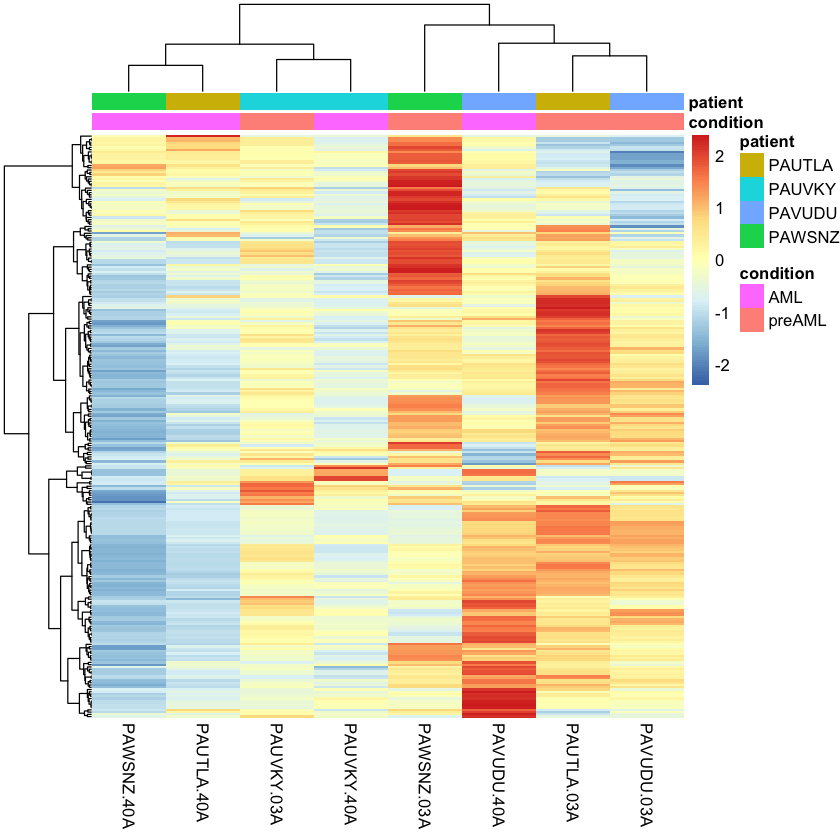

In [69]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [70]:
featureData[head(rownames(significant_expression),5),2]

[1] "PABPC1" "PABPC1" "RPL13A" "PTMA"   "ACTB"

In [71]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)
top_significant_genes <- dge[rownames(significant_genes),]

[1] 258

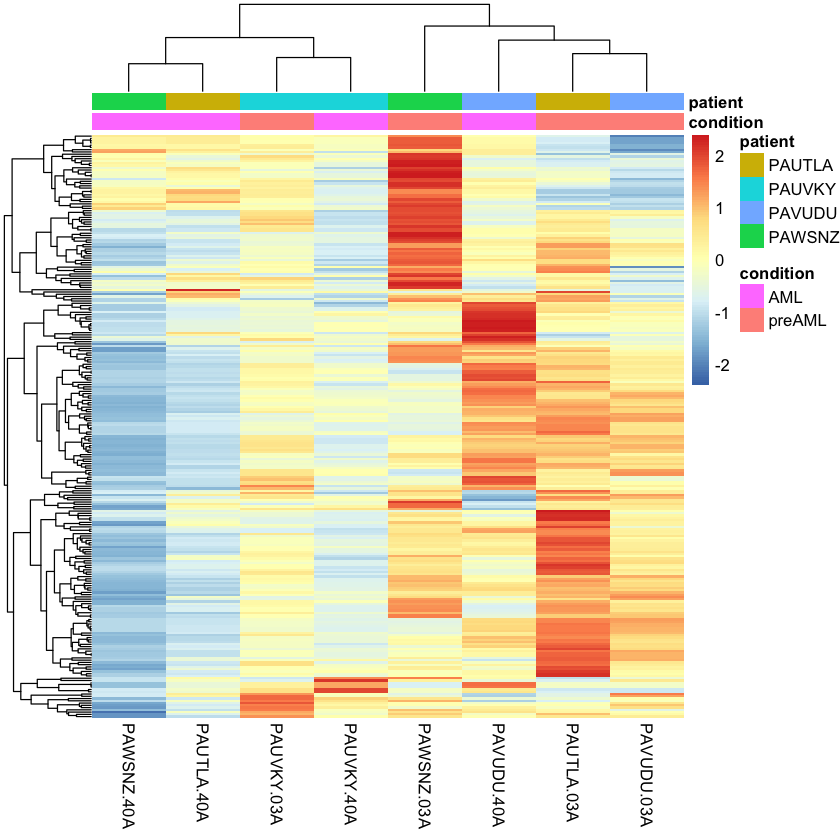

In [72]:
start=1
stop=length(top_gene_list)
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece <- pheatmap(piece, 
                     cluster_rows5=TRUE, 
                     show_rownames=FALSE,
                     cluster_cols=TRUE, 
                     annotation_col=df, 
                     scale="row",
                     clustering_distance_cols = "minkowski", 
                     clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"vwts_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

In [73]:
dim(piece)
colnames(piece)

# Convert column names to indices
paired_preAML_indices <- which(colnames(piece) %in% paired_preAML_cols)
paired_AML_indices  <- which(colnames(piece) %in% paired_AML_cols)
paired_preAML_indices
paired_AML_indices
# Order by preAML elements, followed by AML elements
piece_exp <- piece[,c(paired_preAML_indices,paired_AML_indices)]
colnames(piece_exp)


[1] 258   8

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

[1] 1 3 5 7

[1] 2 4 6 8

[1] "PAUVKY.03A" "PAWSNZ.03A" "PAUTLA.03A" "PAVUDU.03A" "PAUVKY.40A"
[6] "PAWSNZ.40A" "PAUTLA.40A" "PAVUDU.40A"

In [74]:
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"vwts_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"vwts_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)
violin_plot_filename = piece_exp_filename

In [75]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
save_pheatmap_pdf(outpiece, paste(date,"final_matrix_vwts_9fold_top_significant_genes.pdf",sep="_"))

pdf 
  2

In [76]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 4 groups - should check the dendogram every time to choose major grouping
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=4)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]

cluster_1_filename <- paste(paste(date, "vwts_cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "vwts_cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "vwts_cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "vwts_cluster_4", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)

[1] 258   2

[1] 4514   11
[1] 11  3
[1] 4514   11
[1] 11


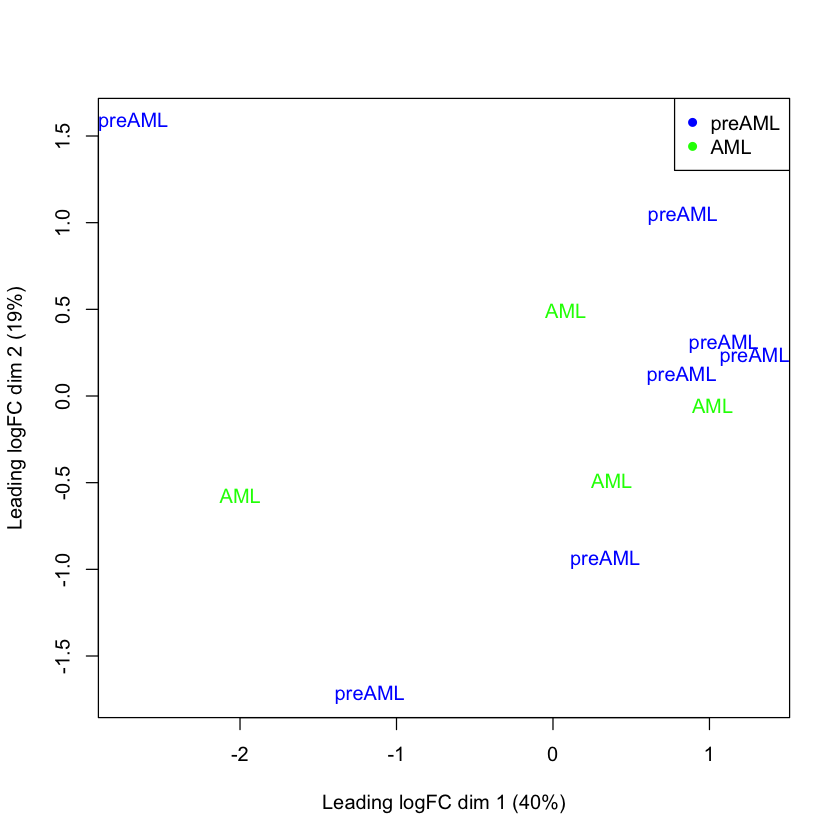

In [77]:
#
# 2. unpaired analyses unpaired preAML to paired AML
#    key input matrices are:
#    a. coldata_unpaired_preAML_paired_AML
#    b. combined_final_unpaired_preAML_paired_AML_cts
#
date<-"2024Aug22_A3SS_unpaired_preAML_paired_AML_"

combined_final_unpaired_preAML_paired_AML_cts <- combined_final_unpaired_preAML_paired_AML_matrix

# Check dimensions
print(dim(combined_final_unpaired_preAML_paired_AML_cts))
print(dim(coldata_unpaired_preAML_paired_AML))

# Ensure matrix has the same number of rows as cts has columns
if (nrow(coldata_unpaired_preAML_paired_AML) != ncol(combined_final_unpaired_preAML_paired_AML_cts)) {
  stop("The number of samples in coldata_paired and paired_cts do not match.")
}

# Convert the count data to a DGEList object
dge <- DGEList(counts = combined_final_unpaired_preAML_paired_AML_cts)

# Normalize the data using the TMM method
dge <- calcNormFactors(dge)

# Compute the log-transformed counts per million (CPM)
logCPM <- cpm(dge, log = TRUE, prior.count = 3)

# Ensure coldata_paired$condition is a factor and create a color palette
coldata_unpaired_preAML_paired_AML$condition <- factor(coldata_unpaired_preAML_paired_AML$condition, levels = c("preAML", "AML"))
color_palette <- c("blue", "green")

# Map the conditions to their respective colors
condition_colors <- color_palette[as.numeric(coldata_unpaired_preAML_paired_AML$condition)]

# Check lengths of logCPM and condition_colors
print(dim(logCPM))
print(length(condition_colors))

# Ensure the lengths match
if (ncol(logCPM) != length(condition_colors)) {
  stop("The number of col in logCPM and the length of condition_colors do not match.")
}

# Create MDS plot with colors for each condition
plotMDS(logCPM, col = condition_colors, labels = coldata_unpaired_preAML_paired_AML$condition)
legend("topright", legend = levels(coldata_unpaired_preAML_paired_AML$condition), col = color_palette, pch = 16)

In [78]:
coldata_unpaired_preAML_paired_AML
# Create a factor for the conditions
group <- factor(coldata_unpaired_preAML_paired_AML$condition)

# Create the design matrix
design <- model.matrix(~0 + group)
colnames(design) <- levels(group)

fit <- lmFit(logCPM, design)
fit <- eBayes(fit, trend=TRUE)

de_results <- topTable(fit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(lookup)
head(featureData[lookup,2])

,patient,condition,paired
,<chr>,<fct>,<chr>
PAUVKY.40A,PAUVKY,AML,yes
PAUTLA.40A,PAUTLA,AML,yes
PAVUDU.40A,PAVUDU,AML,yes
PAWSNZ.40A,PAWSNZ,AML,yes
PAUWWN.03A,PAUWWN,preAML,no
PAVLZB.03A,PAVLZB,preAML,no
PAVWDK.03A,PAVWDK,preAML,no
PAVXBW.03A,PAVXBW,preAML,no
PAXDWD.03A,PAXDWD,preAML,no


[1] 4514

[1] "UBA52"  "RPL18"  "RPS7"   "PFDN5"  "PABPC1" "RPL4"

In [79]:
# There are too many values - lets reduce the size a bit more
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 267   6

In [80]:
lookup <- rownames(significant_genes)
df <- as.data.frame(coldata[,c("condition","patient")])

significant_expression <- dge[lookup,]
dim(significant_expression)
length(lookup)

[1] 267  11

[1] 267

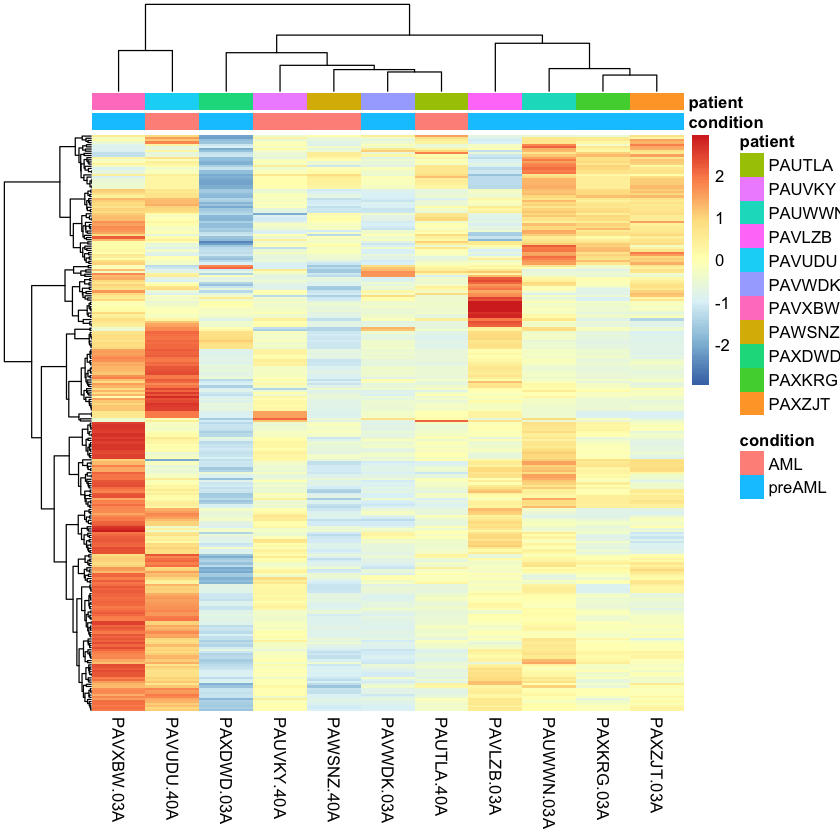

In [81]:
library("pheatmap")

significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

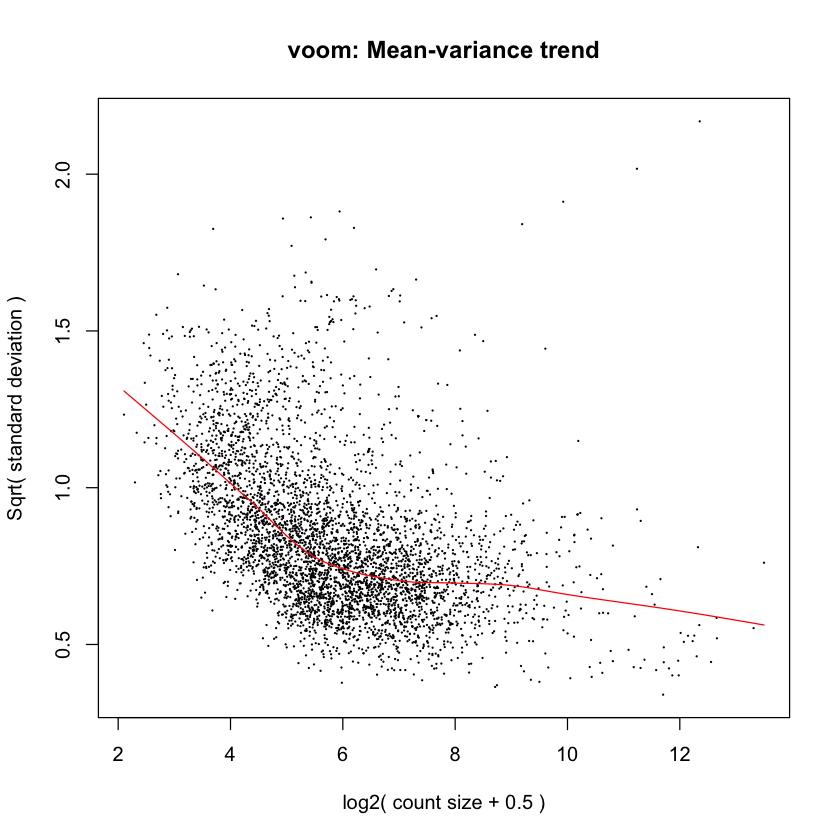

In [82]:
# voom 
v <- voom(dge, plot=TRUE, normalize="quantile")

In [83]:
vfit <- lmFit(v, design)
vfit <- eBayes(vfit, trend=TRUE)
de_results <- topTable(vfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 4514

[1] "RPL13A" "RPL4"   "RPL7A"  "RPS2"   "RPS2"   "RPLP0"

In [84]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 261   6

In [85]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

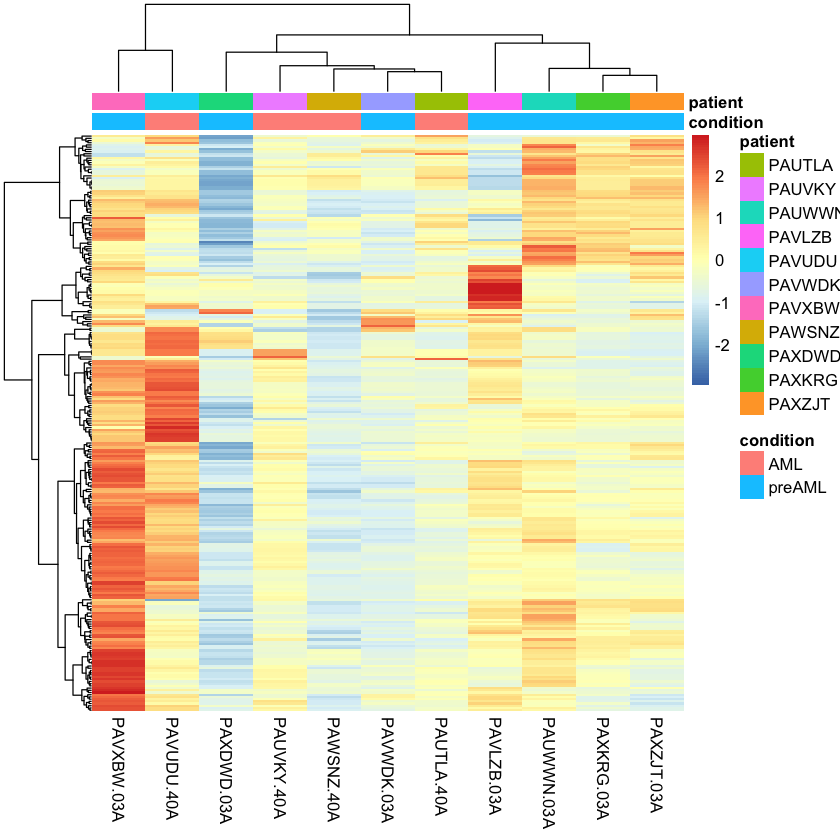

In [86]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [87]:
featureData[head(rownames(significant_expression),5),2]

[1] "RPL13A" "RPL4"   "RPL7A"  "RPS2"   "RPS2"

In [88]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

[1] 261

In [89]:
top_significant_genes <- dge[rownames(significant_genes),]

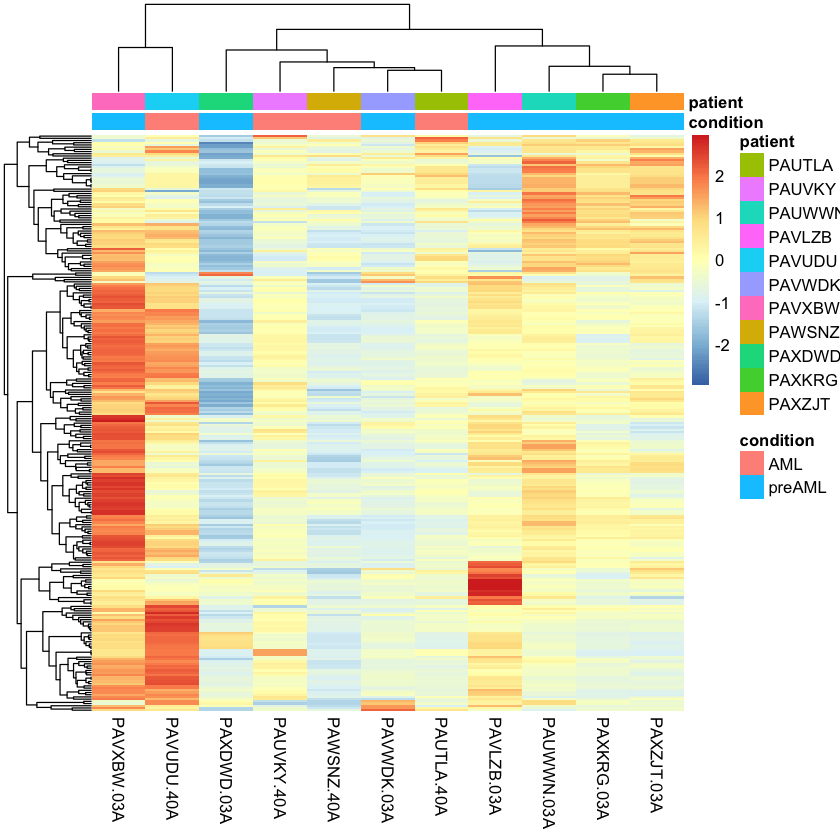

In [90]:
start=1
stop=length(top_gene_list)
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, 
                   cluster_rows5=TRUE, 
                   show_rownames=FALSE,
                   cluster_cols=TRUE, 
                   annotation_col=df, 
                   scale="row",
                   clustering_distance_cols = "minkowski", 
                   clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"voom_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

In [91]:
dim(piece)
colnames(piece)

# Convert column names to indices
unpaired_preAML_indices <- which(colnames(piece) %in% unpaired_preAML_cols)
paired_AML_indices  <- which(colnames(piece) %in% paired_AML_cols)
unpaired_preAML_indices
paired_AML_indices
# Order by preAML elements, followed by AML elements
piece_exp <- piece[,c(unpaired_preAML_indices,paired_AML_indices)]
colnames(piece_exp)

rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"voom_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"voom_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

[1] 261  11

[1] "PAUVKY.40A" "PAUWWN.03A" "PAVLZB.03A" "PAVWDK.03A" "PAVXBW.03A"
 [6] "PAWSNZ.40A" "PAXDWD.03A" "PAXKRG.03A" "PAXZJT.03A" "PAUTLA.40A"
[11] "PAVUDU.40A"

[1] 2 3 4 5 7 8 9

[1]  1  6 10 11

[1] "PAUWWN.03A" "PAVLZB.03A" "PAVWDK.03A" "PAVXBW.03A" "PAXDWD.03A"
 [6] "PAXKRG.03A" "PAXZJT.03A" "PAUVKY.40A" "PAWSNZ.40A" "PAUTLA.40A"
[11] "PAVUDU.40A"

In [92]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 4 major groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=4)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]

cluster_1_filename <- paste(paste(date, "voom_cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "voom_cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "voom_cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "voom_cluster_4", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)


[1] 261   2

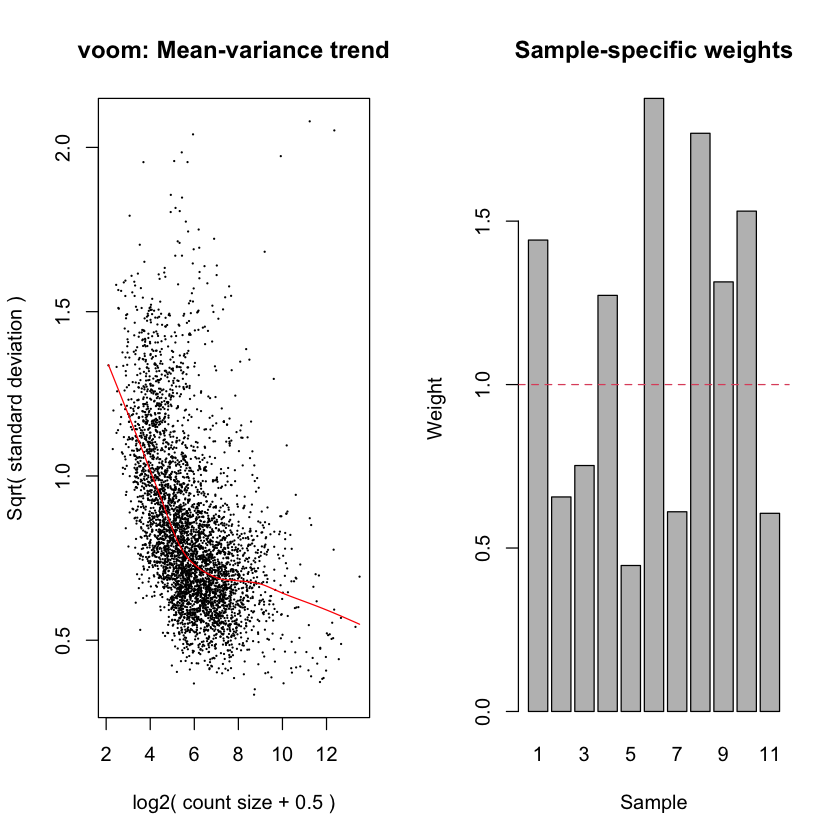

In [93]:
vwts <- voomWithQualityWeights(dge, design=design, normalize.method="quantile", plot=TRUE)

In [94]:
vwtsfit <- lmFit(vwts, design, weights = vwts$weights )
# no other weighting at this time.
 #* c(1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0))

In [95]:
vwtsfit <- eBayes(vwtsfit, trend=TRUE)
de_results <- topTable(vwtsfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 4514

[1] "RPL13A" "RPLP0"  "RPS2"   "RPS7"   "RPL7A"  "RPL4"

In [96]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 268   6

In [97]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]
head(significant_genes)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7567,13.09933,13.14006,111.5216,4.724891e-21,4.366730e-18,34.69333
3525,13.32934,13.24500,104.6176,1.098856e-20,6.732543e-18,34.45493
5580,12.47510,12.45044,113.6306,3.689170e-21,4.366730e-18,34.36000
8589,12.44553,12.39106,113.3090,3.829901e-21,4.366730e-18,34.32440
13617,12.54015,12.56436,111.3240,4.836875e-21,4.366730e-18,34.28909
4987,12.30158,12.28658,113.7530,3.637065e-21,4.366730e-18,34.24346


In [98]:
head(featureData[lookup,2])

[1] "RPL13A" "RPLP0"  "RPS2"   "RPS7"   "RPL7A"  "RPL4"

In [99]:
head(significant_expression)

An object of class "DGEList"
$counts
      PAUVKY.40A PAUWWN.03A PAVLZB.03A PAVWDK.03A PAVXBW.03A PAWSNZ.40A
7567        5698       9630       5938       3990       9342       3973
3525        7155       7492       8688       4504      13261       3059
5580        4485       4755       3681       2765       6130       2245
8589        4043       4393       4222       2764       5674       2079
13617       4609       4925       4793       2257       7114       2519
4987        3453       4610       3837       2252       6432       1808
      PAXDWD.03A PAXKRG.03A PAXZJT.03A PAUTLA.40A PAVUDU.40A
7567        2156       8708       8249       5197      10635
3525        3231       7230       6908       4681      12571
5580        1519       4615       4450       2924       8155
8589        1614       3934       4429       3153       7122
13617       2142       4327       4379       3175       8141
4987        1570       3961       4159       2733       5769

$samples
           group lib.size norm.factors
PAUVKY.40A     1   661174    1.0205657
PAUWWN.03A     1   899808    1.0082970
PAVLZB.03A     1   738773    0.9149200
PAVWDK.03A     1   520985    1.1247452
PAVXBW.03A     1  1163997    0.8869012
6 more rows ...

In [100]:
unpaired_preAML_paired_AML_final_matrix <- significant_expression$counts

rownames(unpaired_preAML_paired_AML_final_matrix) <- lookup
head(unpaired_preAML_paired_AML_final_matrix)
write.csv(unpaired_preAML_paired_AML_final_matrix, "unpaired_preAML_paired_AML_final_matrix.csv",quote=FALSE)

,PAUVKY.40A,PAUWWN.03A,PAVLZB.03A,PAVWDK.03A,PAVXBW.03A,PAWSNZ.40A,PAXDWD.03A,PAXKRG.03A,PAXZJT.03A,PAUTLA.40A,PAVUDU.40A
7567,5698,9630,5938,3990,9342,3973,2156,8708,8249,5197,10635
3525,7155,7492,8688,4504,13261,3059,3231,7230,6908,4681,12571
5580,4485,4755,3681,2765,6130,2245,1519,4615,4450,2924,8155
8589,4043,4393,4222,2764,5674,2079,1614,3934,4429,3153,7122
13617,4609,4925,4793,2257,7114,2519,2142,4327,4379,3175,8141
4987,3453,4610,3837,2252,6432,1808,1570,3961,4159,2733,5769


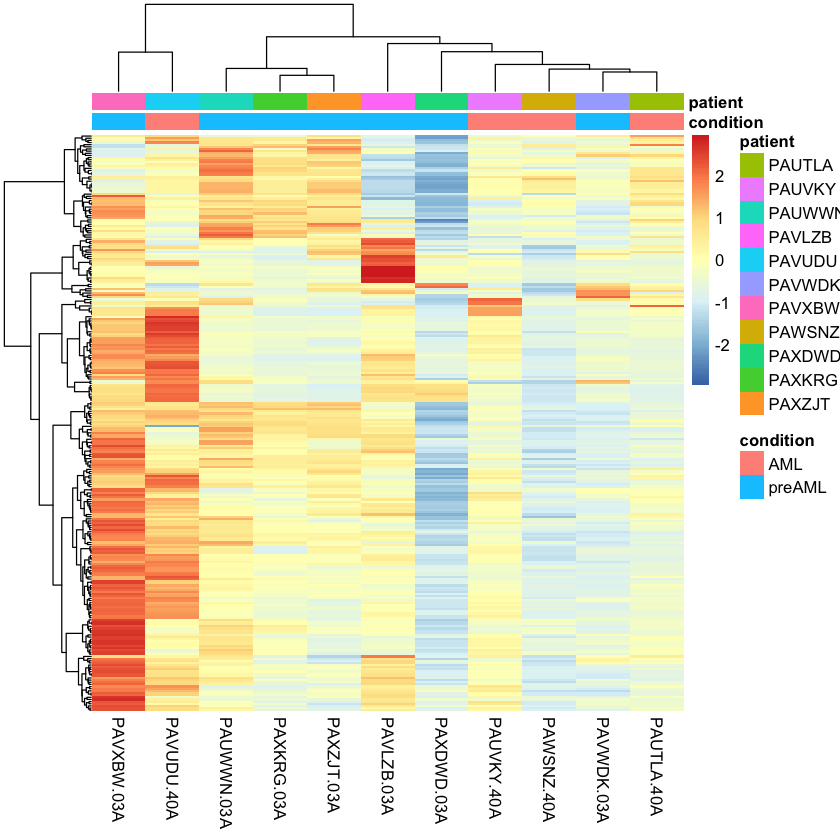

In [101]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [102]:
featureData[head(rownames(significant_expression),5),2]

[1] "RPL13A" "RPLP0"  "RPS2"   "RPS7"   "RPL7A"

In [103]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)
top_significant_genes <- dge[rownames(significant_genes),]

[1] 268

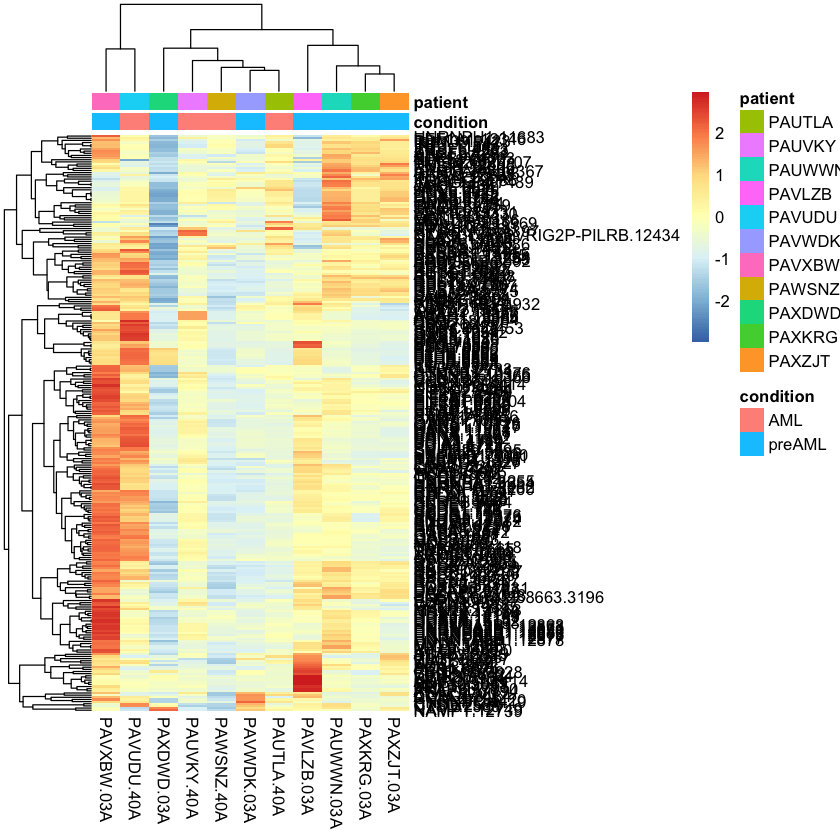

In [104]:
start=1
stop=length(top_gene_list)
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, 
                   cluster_rows5=TRUE, 
                   show_rownames=TRUE,
                   cluster_cols=TRUE, 
                   annotation_col=df, 
                   scale="row",
                   clustering_distance_cols = "minkowski", 
                   clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"vwts_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

In [105]:
dim(piece)
colnames(piece)

# Convert column names to indices
unpaired_preAML_indices <- which(colnames(piece) %in% unpaired_preAML_cols)
paired_AML_indices  <- which(colnames(piece) %in% paired_AML_cols)
unpaired_preAML_indices
paired_AML_indices
# Order by preAML elements, followed by AML elements
piece_exp <- piece[,c(unpaired_preAML_indices,paired_AML_indices)]
colnames(piece_exp)


[1] 268  11

[1] "PAUVKY.40A" "PAUWWN.03A" "PAVLZB.03A" "PAVWDK.03A" "PAVXBW.03A"
 [6] "PAWSNZ.40A" "PAXDWD.03A" "PAXKRG.03A" "PAXZJT.03A" "PAUTLA.40A"
[11] "PAVUDU.40A"

[1] 2 3 4 5 7 8 9

[1]  1  6 10 11

[1] "PAUWWN.03A" "PAVLZB.03A" "PAVWDK.03A" "PAVXBW.03A" "PAXDWD.03A"
 [6] "PAXKRG.03A" "PAXZJT.03A" "PAUVKY.40A" "PAWSNZ.40A" "PAUTLA.40A"
[11] "PAVUDU.40A"

In [106]:
# Order by TAM elements, followed by AML elements
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)
violin_plot_filename = piece_exp_filename

In [107]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
filename <- paste(paste(paste(paste(date,"final_matrix_significant_genes",sep="_"),start,sep="_"),stop,sep="_"),"pdf",sep=".")
save_pheatmap_pdf(outpiece, filename)

pdf 
  2

In [108]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 4 groups - should check the dendogram every time to choose major grouping
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=4)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]

cluster_1_filename <- paste(paste(date, "_paired_A3SS_vwts_cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "_paired_A3SS_vwts_cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "_paired_A3SS_vwts_cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "_paired_A3SS_vwts_cluster_4", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)


[1] 268   2

In [111]:
#
# 3. combining unpaired noAML with unpaired preAML
date<-"2024Sep10_A3SS_unpaired_noAML_unpaired_preAML_"
combined_final_unpaired_noAML_unpaired_preAML_cts <- combined_final_unpaired_noAML_unpaired_preAML_matrix

# Check dimensions
print(dim(combined_final_unpaired_noAML_unpaired_preAML_cts))
print(dim(coldata_unpaired_noAML_unpaired_preAML))

# Ensure matrix has the same number of rows as cts has columns
if (nrow(coldata_unpaired_noAML_unpaired_preAML) != ncol(combined_final_unpaired_noAML_unpaired_preAML_cts)) {
  stop("The number of samples in coldata and cts do not match.")
}


[1] 3386  106
[1] 106   3


[1] 3386  106
[1] 106


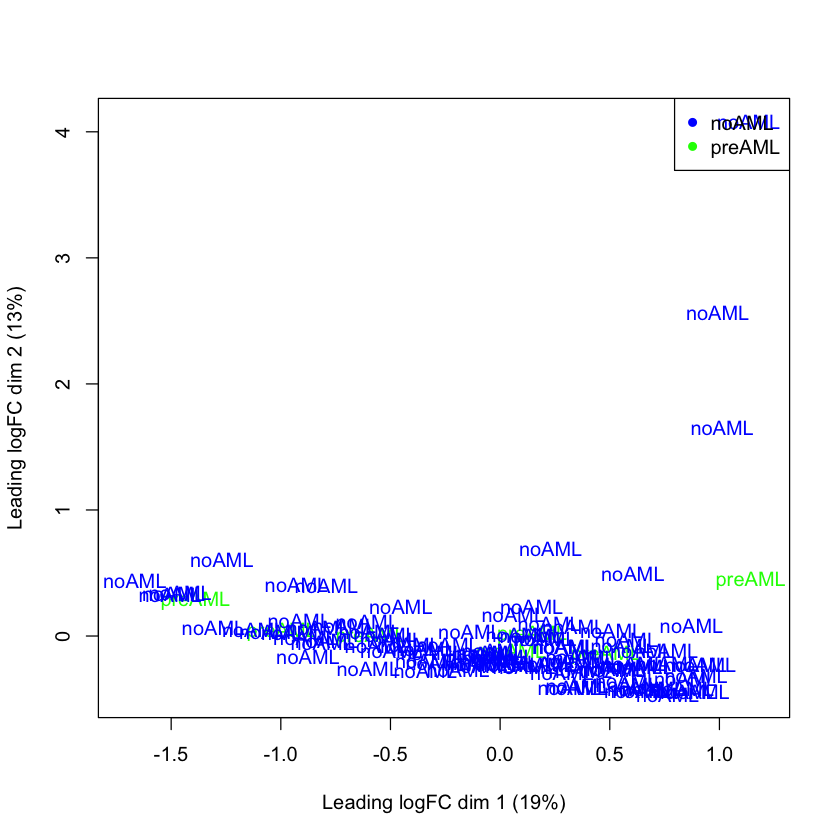

In [112]:
# Convert the count data to a DGEList object
dge <- DGEList(counts = combined_final_unpaired_noAML_unpaired_preAML_cts)

# Normalize the data using the TMM method
dge <- calcNormFactors(dge)

# Compute the log-transformed counts per million (CPM)
logCPM <- cpm(dge, log = TRUE, prior.count = 3)

# Ensure $condition is a factor and create a color palette
coldata_unpaired_noAML_unpaired_preAML$condition <- factor(coldata_unpaired_noAML_unpaired_preAML$condition, levels = c("noAML", "preAML"))
color_palette <- c("blue", "green")

# Map the conditions to their respective colors
condition_colors <- color_palette[as.numeric(coldata_unpaired_noAML_unpaired_preAML$condition)]

# Check lengths of logCPM and condition_colors
print(dim(logCPM))
print(length(condition_colors))

# Ensure the lengths match
if (ncol(logCPM) != length(condition_colors)) {
  stop("The number of col in logCPM and the length of condition_colors do not match.")
}

# Create MDS plot with colors for each condition
plotMDS(logCPM, col = condition_colors, labels = coldata_unpaired_noAML_unpaired_preAML$condition)
legend("topright", legend = levels(coldata_unpaired_noAML_unpaired_preAML$condition), col = color_palette, pch = 16)

In [113]:
#coldata_unpaired_noAML_paired_preAML
# Create a factor for the conditions
group <- factor(coldata_unpaired_noAML_unpaired_preAML$condition)

# Create the design matrix
design <- model.matrix(~0 + group)
colnames(design) <- levels(group)

fit <- lmFit(logCPM, design)
fit <- eBayes(fit, trend=TRUE)

de_results <- topTable(fit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(lookup)
head(featureData[lookup,2])

[1] 3386

[1] "UBA52"  "DDX39B" "RPS7"   "PABPC1" "PABPC1" "PMPCB"

In [114]:
# There are too many values - lets reduce the size a bit more
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 280   6

In [115]:
lookup <- rownames(significant_genes)
df <- as.data.frame(coldata[,c("condition","patient")])

significant_expression <- dge[lookup,]
dim(significant_expression)
length(lookup)

[1] 280 106

[1] 280

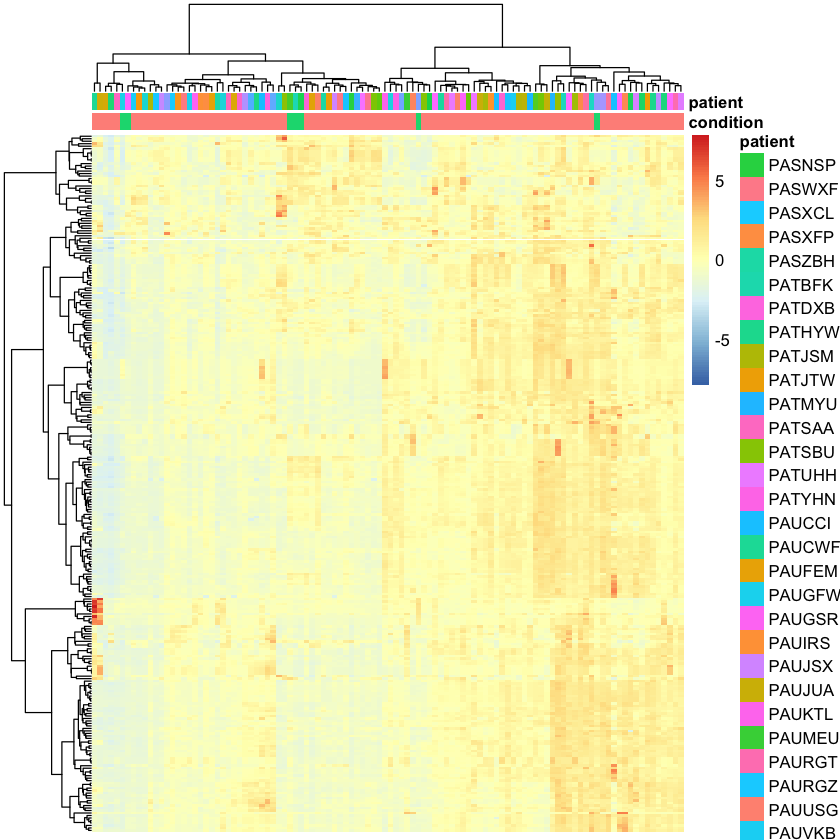

In [116]:
library("pheatmap")

significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            show_colnames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

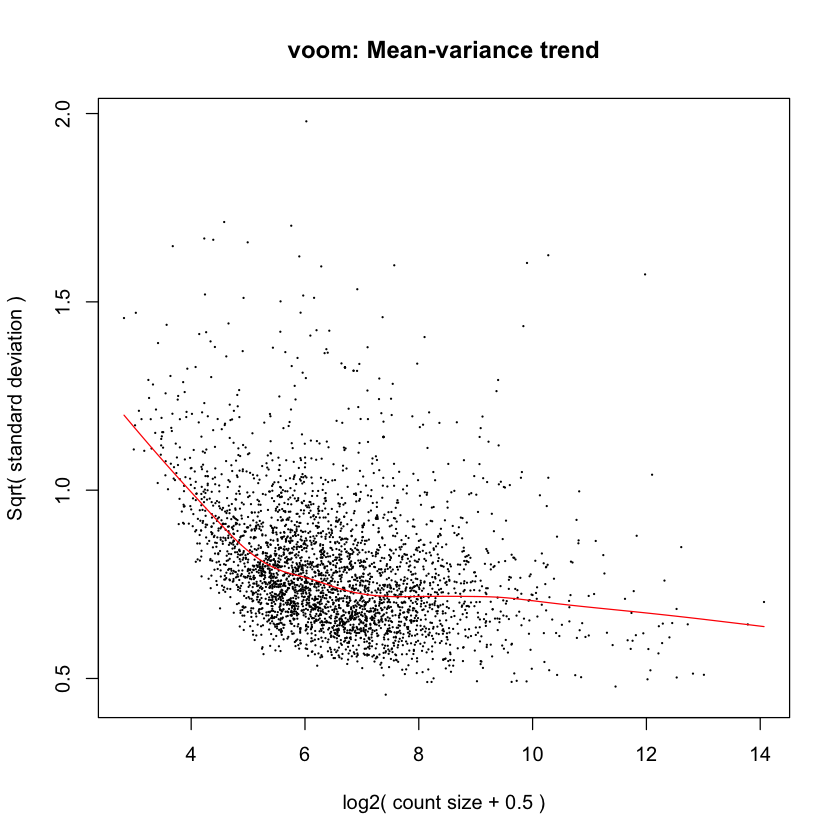

In [117]:
# voom 
v <- voom(dge, plot=TRUE, normalize="quantile")

In [118]:
vfit <- lmFit(v, design)
vfit <- eBayes(vfit, trend=TRUE)
de_results <- topTable(vfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 3386

[1] "RPLP0" "RPS3"  "RPLP0" "UBA52" "RPS7"  "RPLP0"

In [119]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 295   6

In [120]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

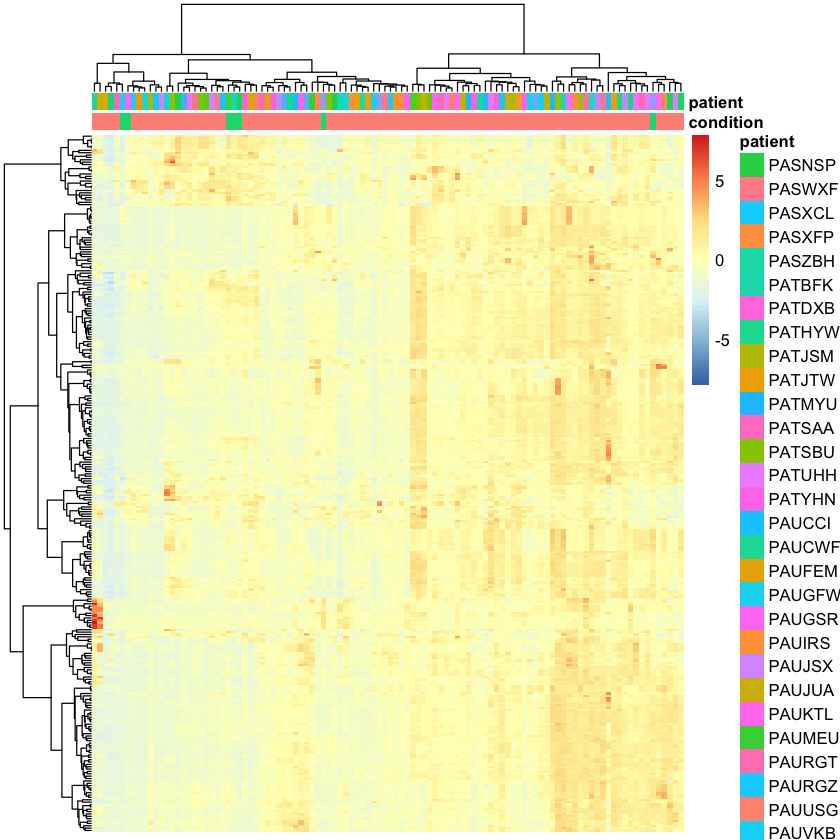

In [121]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            show_colnames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [122]:
featureData[head(rownames(significant_expression),5),2]

[1] "RPLP0" "RPS3"  "RPLP0" "UBA52" "RPS7"

In [123]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

[1] 295

In [124]:
top_significant_genes <- dge[rownames(significant_genes),]

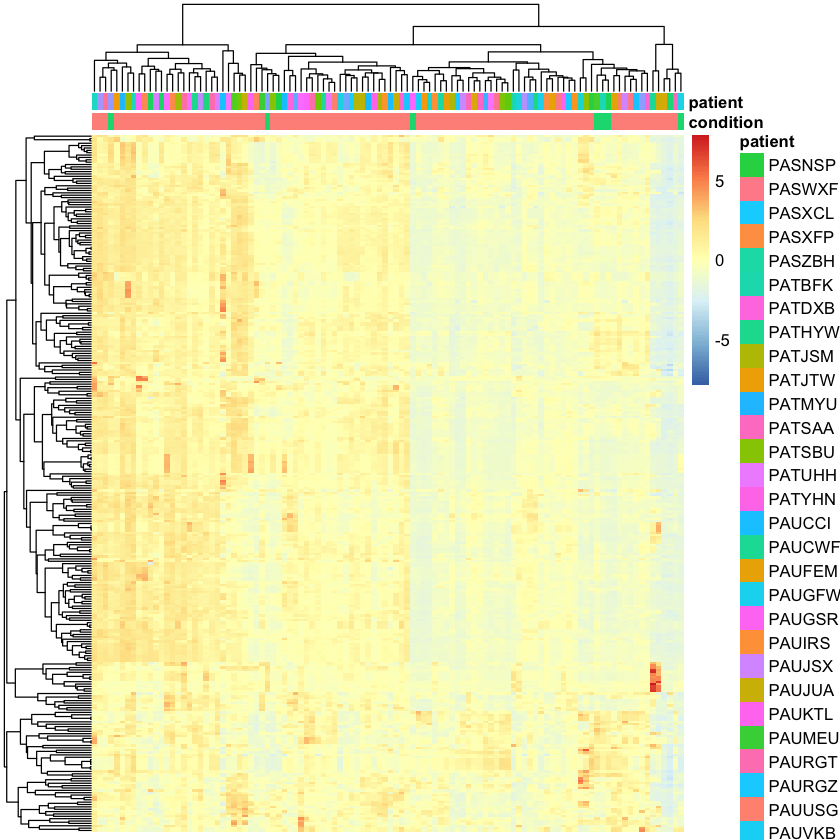

In [125]:
start=1
stop=length(top_gene_list)
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, 
                   cluster_rows5=TRUE, 
                   show_rownames=FALSE,
                   cluster_cols=TRUE, 
                   show_colnames=FALSE,
                   annotation_col=df, 
                   scale="row",
                   clustering_distance_cols = "minkowski", 
                   clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"voom_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

In [126]:
dim(piece)
colnames(piece)

# Convert column names to indices
unpaired_noAML_indices <- which(colnames(piece) %in% unpaired_noAML_cols)
paired_AML_indices  <- which(colnames(piece) %in% paired_AML_cols)
unpaired_noAML_indices
paired_AML_indices
# Order by preAML elements, followed by AML elements
piece_exp <- piece[,c(unpaired_noAML_indices,paired_AML_indices)]
colnames(piece_exp)

rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"voom_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"voom_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

[1] 295 106

[1] "PASNSP.03A" "PASWXF.03A" "PASXCL.03A" "PASXFP.03A" "PASZBH.03A"
  [6] "PATBFK.03A" "PATDXB.03A" "PATHYW.03A" "PATJSM.03A" "PATJTW.03A"
 [11] "PATMYU.03A" "PATSAA.03A" "PATSBU.03A" "PATUHH.03A" "PATYHN.03A"
 [16] "PAUCCI.03A" "PAUCWF.03A" "PAUFEM.03A" "PAUGFW.03A" "PAUGSR.03A"
 [21] "PAUIRS.03A" "PAUJSX.03A" "PAUJUA.03A" "PAUKTL.03A" "PAUMEU.03A"
 [26] "PAURGT.03A" "PAURGZ.03A" "PAUUSG.03A" "PAUVKB.03A" "PAUWDM.03A"
 [31] "PAUWDN.03A" "PAUWWN.03A" "PAUXAT.03A" "PAUXEH.03A" "PAUYAY.03A"
 [36] "PAVCVG.03A" "PAVDZT.03A" "PAVECW.03A" "PAVESU.03A" "PAVIIZ.03A"
 [41] "PAVKZU.03A" "PAVLZB.03A" "PAVMSZ.03A" "PAVNSJ.03A" "PAVNXY.03A"
 [46] "PAVPJC.03A" "PAVRGG.03A" "PAVVPL.03A" "PAVWDK.03A" "PAVWVF.03A"
 [51] "PAVXBW.03A" "PAWBDC.03A" "PAWCAY.03A" "PAWCPC.03A" "PAWDIN.03A"
 [56] "PAWEUI.03A" "PAWFKB.03A" "PAWGFN.03A" "PAWGHI.03A" "PAWGIG.03A"
 [61] "PAWHHS.03A" "PAWIAD.03A" "PAWJDZ.03A" "PAWKFB.03A" "PAWRJN.03A"
 [66] "PAWSIP.03A" "PAWSUI.03A" "PAWVNF.03A" "PAWVRU.03A" "PAWWPI.03A"
 [71] "PAWXEX.03A" "PAWXPM.03A" "PAWYII.03A" "PAWYKF.03A" "PAXAWN.03A"
 [76] "PAXBAL.03A" "PAXBFM.03A" "PAXCUK.03A" "PAXDHB.03A" "PAXDWD.03A"
 [81] "PAXGLA.03A" "PAXHDZ.03A" "PAXHVP.03A" "PAXHYL.03A" "PAXJYG.03A"
 [86] "PAXKRG.03A" "PAXNFN.03A" "PAXNKT.03A" "PAXPLA.03A" "PAXSBH.03A"
 [91] "PAXSSI.03A" "PAXWGW.03A" "PAXWZW.03A" "PAXXCC.03A" "PAXZJT.03A"
 [96] "PAXZLD.03A" "PAYAXU.03A" "PAYDIX.03A" "PAYDXU.03A" "PAYDYT.03A"
[101] "PAYEGL.03A" "PAYFEJ.03A" "PAYFLR.03A" "PAYJHN.03A" "PAYJHS.03A"
[106] "PAYLHE.03A"

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
[20]  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38  39
[39]  40  41  43  44  45  46  47  48  50  52  53  54  55  56  57  58  59  60  61
[58]  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  81
[77]  82  83  84  85  87  88  89  90  91  92  93  94  96  97  98  99 100 101 102
[96] 103 104 105 106

integer(0)

[1] "PASNSP.03A" "PASWXF.03A" "PASXCL.03A" "PASXFP.03A" "PASZBH.03A"
 [6] "PATBFK.03A" "PATDXB.03A" "PATHYW.03A" "PATJSM.03A" "PATJTW.03A"
[11] "PATMYU.03A" "PATSAA.03A" "PATSBU.03A" "PATUHH.03A" "PATYHN.03A"
[16] "PAUCCI.03A" "PAUCWF.03A" "PAUFEM.03A" "PAUGFW.03A" "PAUGSR.03A"
[21] "PAUIRS.03A" "PAUJSX.03A" "PAUJUA.03A" "PAUKTL.03A" "PAUMEU.03A"
[26] "PAURGT.03A" "PAURGZ.03A" "PAUUSG.03A" "PAUVKB.03A" "PAUWDM.03A"
[31] "PAUWDN.03A" "PAUXAT.03A" "PAUXEH.03A" "PAUYAY.03A" "PAVCVG.03A"
[36] "PAVDZT.03A" "PAVECW.03A" "PAVESU.03A" "PAVIIZ.03A" "PAVKZU.03A"
[41] "PAVMSZ.03A" "PAVNSJ.03A" "PAVNXY.03A" "PAVPJC.03A" "PAVRGG.03A"
[46] "PAVVPL.03A" "PAVWVF.03A" "PAWBDC.03A" "PAWCAY.03A" "PAWCPC.03A"
[51] "PAWDIN.03A" "PAWEUI.03A" "PAWFKB.03A" "PAWGFN.03A" "PAWGHI.03A"
[56] "PAWGIG.03A" "PAWHHS.03A" "PAWIAD.03A" "PAWJDZ.03A" "PAWKFB.03A"
[61] "PAWRJN.03A" "PAWSIP.03A" "PAWSUI.03A" "PAWVNF.03A" "PAWVRU.03A"
[66] "PAWWPI.03A" "PAWXEX.03A" "PAWXPM.03A" "PAWYII.03A" "PAWYKF.03A"
[71] "PAXAWN.03A" "PAXBAL.03A" "PAXBFM.03A" "PAXCUK.03A" "PAXDHB.03A"
[76] "PAXGLA.03A" "PAXHDZ.03A" "PAXHVP.03A" "PAXHYL.03A" "PAXJYG.03A"
[81] "PAXNFN.03A" "PAXNKT.03A" "PAXPLA.03A" "PAXSBH.03A" "PAXSSI.03A"
[86] "PAXWGW.03A" "PAXWZW.03A" "PAXXCC.03A" "PAXZLD.03A" "PAYAXU.03A"
[91] "PAYDIX.03A" "PAYDXU.03A" "PAYDYT.03A" "PAYEGL.03A" "PAYFEJ.03A"
[96] "PAYFLR.03A" "PAYJHN.03A" "PAYJHS.03A" "PAYLHE.03A"

In [127]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 4 major groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=4)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]

cluster_1_filename <- paste(paste(date, "voom_cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "voom_cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "voom_cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "voom_cluster_4", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)


[1] 295   2

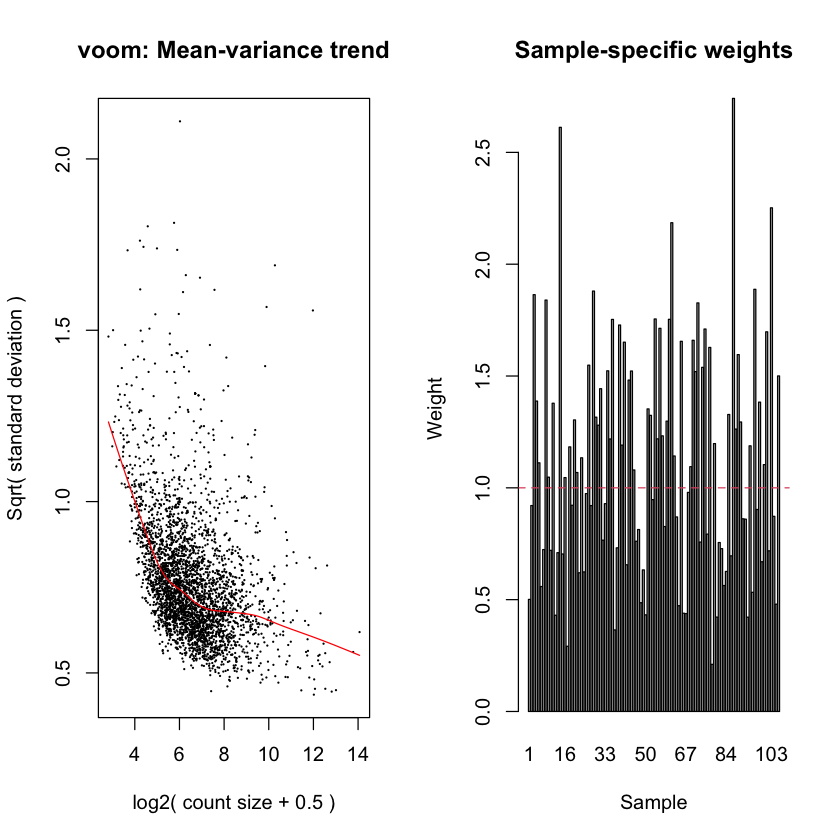

In [128]:
vwts <- voomWithQualityWeights(dge, design=design, normalize.method="quantile", plot=TRUE)

In [129]:
vwtsfit <- lmFit(vwts, design, weights = vwts$weights )
# no other weighting at this time.
 #* c(1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0))

In [130]:
vwtsfit <- eBayes(vwtsfit, trend=TRUE)
de_results <- topTable(vwtsfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 3386

[1] "RPS3"  "RPLP0" "RPS7"  "RPLP0" "RPLP0" "UBA52"

In [131]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 295   6

In [132]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]
head(significant_genes)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2428,13.25829,13.23917,174.5527,4.228464e-135,1.279745e-131,289.5402
3525,13.46337,13.43119,173.6202,7.559038e-135,1.279745e-131,289.4309
8589,12.49648,12.44006,167.7623,3.125429e-133,3.527567e-130,284.7427
3536,13.07423,12.95287,164.9258,1.985316e-132,1.680570e-129,284.1996
3528,12.59811,12.49110,158.3959,1.583456e-130,1.072317e-127,279.8446
7278,11.90640,11.87845,151.1231,2.579082e-128,1.455462e-125,274.6287


In [133]:
head(featureData[lookup,2])

[1] "RPS3"  "RPLP0" "RPS7"  "RPLP0" "RPLP0" "UBA52"

In [134]:
head(significant_expression)

An object of class "DGEList"
$counts
     PASNSP.03A PASWXF.03A PASXCL.03A PASXFP.03A PASZBH.03A PATBFK.03A
2428       7500       6880       5132       6889       5563       5285
3525       7835       7260       8142       8344       7043       5943
8589       4954       4251       3460       3949       4195       2215
3536       5075       4889       5199       5872       5330       4729
3528       4299       3980       4211       4204       3976       3355
7278       2743       2757       2559       2300       2289       2281
     PATDXB.03A PATHYW.03A PATJSM.03A PATJTW.03A PATMYU.03A PATSAA.03A
2428       6357       9621       4742       5689      13200       1861
3525       6186      13747       4840       5656      16094       2280
8589       3462       5888       2519       4001       7540       1311
3536       4494       9156       3380       4019      12137       1489
3528       3438       7061       2692       3068       8287       1223
7278       2211       3942       1420       2170       4881        697
     PATSBU.03A PATUHH.03A PATYHN.03A PAUCCI.03A PAUCWF.03A PAUFEM.03A
2428       7916       7211       8592       8730       2142       6637
3525       9722       8391      10898       9399       2423       7430
8589       4576       4423       5910       4942       1742       4297
3536       7108       5795       7495       6652       2037       5991
3528       4854       4384       5337       4820       1382       4120
7278       2472       3140       3748       2765       2861       2371
     PAUGFW.03A PAUGSR.03A PAUIRS.03A PAUJSX.03A PAUJUA.03A PAUKTL.03A
2428       3976       5619       5422       6192       8555      11390
3525       5748       6714       6253       6937      10856      15320
8589       2391       3517       2880       3938       5368       6534
3536       3533       4090       4403       4887       7798      10635
3528       2856       3401       3347       3923       5424       7803
7278       1788       2444       1746       3040       3135       3438
     PAUMEU.03A PAURGT.03A PAURGZ.03A PAUUSG.03A PAUVKB.03A PAUWDM.03A
2428       6663      11138       4682       6929       9998      10992
3525       8793      13354       4478       8537      13269      13852
8589       3465       5987       2405       4635       6088       6501
3536       6078       9452       2762       6307       9301       9772
3528       4494       6744       2448       4300       6760       7173
7278       2608       3548       1527       3363       3273       4018
     PAUWDN.03A PAUWWN.03A PAUXAT.03A PAUXEH.03A PAUYAY.03A PAVCVG.03A
2428      15234       7142       8569       7198       6232       7737
3525      15375       7492      10842       8635       6761       9798
8589       7323       4393       5867       3842       3885       4564
3536      10880       5454       7871       6152       4991       7276
3528       7768       3669       5429       4480       3347       5230
7278       4462       3598       3462       2330       2892       3482
     PAVDZT.03A PAVECW.03A PAVESU.03A PAVIIZ.03A PAVKZU.03A PAVLZB.03A
2428       6703       6976       5975      10621       9228       6853
3525       6474       6801       7353      12325      12303       8688
8589       4032       4345       3458       5481       5046       4222
3536       4625       5798       4807       8708       8077       6416
3528       3589       3206       3797       6356       6222       4398
7278       2520       3538       2878       3344       3530       2909
     PAVMSZ.03A PAVNSJ.03A PAVNXY.03A PAVPJC.03A PAVRGG.03A PAVVPL.03A
2428      10447      12244       8593      13467       8437      15896
3525      11554      14648      10905      11294      12077      13163
8589       5419       6633       4288       5529       5013       5331
3536       8112      10501       7469       9267       8561       9447
3528       5909       7344       5662       5369       6324       5942
7278       4014       4238       3214       3866       300

In [135]:
unpaired_noAML_paired_AML_final_matrix <- significant_expression$counts

rownames(unpaired_noAML_paired_AML_final_matrix) <- lookup
head(unpaired_noAML_paired_AML_final_matrix)
write.csv(unpaired_noAML_paired_AML_final_matrix, "unpaired_noAML_paired_preAML_final_matrix.csv",quote=FALSE)

,PASNSP.03A,PASWXF.03A,PASXCL.03A,PASXFP.03A,PASZBH.03A,PATBFK.03A,PATDXB.03A,PATHYW.03A,PATJSM.03A,PATJTW.03A,⋯,PAYAXU.03A,PAYDIX.03A,PAYDXU.03A,PAYDYT.03A,PAYEGL.03A,PAYFEJ.03A,PAYFLR.03A,PAYJHN.03A,PAYJHS.03A,PAYLHE.03A
2428,7500,6880,5132,6889,5563,5285,6357,9621,4742,5689,⋯,10059,11922,5931,4621,12100,4485,12349,10368,561,13391
3525,7835,7260,8142,8344,7043,5943,6186,13747,4840,5656,⋯,14496,14484,5334,6682,15473,4260,15299,10564,821,15596
8589,4954,4251,3460,3949,4195,2215,3462,5888,2519,4001,⋯,5957,6901,4132,3176,7436,2699,6974,6327,433,6708
3536,5075,4889,5199,5872,5330,4729,4494,9156,3380,4019,⋯,10415,10669,3451,5314,10592,3347,11202,6973,1099,10968
3528,4299,3980,4211,4204,3976,3355,3438,7061,2692,3068,⋯,7583,7496,2922,3434,8032,2412,7683,5840,493,7590
7278,2743,2757,2559,2300,2289,2281,2211,3942,1420,2170,⋯,3884,3295,2567,1849,4235,1973,4608,2735,771,4490


In [ ]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            show_colnames=FALSE,
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [ ]:
featureData[head(rownames(significant_expression),5),2]

In [ ]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)
top_significant_genes <- dge[rownames(significant_genes),]

In [ ]:
start=1
stop=length(top_gene_list)
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, 
                   cluster_rows5=TRUE, 
                   show_rownames=FALSE,
                   cluster_cols=TRUE, 
                   show_colnames=FALSE,
                   annotation_col=df, 
                   scale="row",
                   clustering_distance_cols = "minkowski", 
                   clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"vwts_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")



In [ ]:
dim(piece)
colnames(piece)

# Convert column names to indices
unpaired_noAML_indices <- which(colnames(piece) %in% unpaired_noAML_cols)
paired_AML_indices  <- which(colnames(piece) %in% paired_AML_cols)
unpaired_noAML_indices
paired_AML_indices

# Order by preAML elements, followed by AML elements
piece_exp <- piece[,c(unpaired_noAML_indices,paired_AML_indices)]
colnames(piece_exp)

# Order by TAM elements, followed by AML elements
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"vwts_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"vwts_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)
violin_plot_filename = piece_exp_filename

In [ ]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
filename <- paste(date,"vwts_10fold_top_significant_genes.pdf",sep="_")
save_pheatmap_pdf(outpiece,filename)

In [ ]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 4 groups - should check the dendogram every time to choose major grouping
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=4)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]

cluster_1_filename <- paste(paste(date, "vwts_cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "vwts_cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "vwts_cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "vwts_cluster_4", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)


